In [2]:
import os

import pandas as pd
import janitor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pyo.init_notebook_mode()

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

import country_converter as coco
cc = coco.CountryConverter()


%matplotlib inline

In [3]:
os.makedirs('plot_html',exist_ok=True)

In [4]:
import chart_studio.plotly as py
import plotly.graph_objects as go

trace0 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = [trace0, trace1]

py.plot(data, filename = 'basic-line', auto_open=True)

'https://plotly.com/~radvanyimome/5/'

In [5]:
# Seaborn palette
# sns.set_theme(context='notebook', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)
# sns.palplot(sns.color_palette())

In [6]:
outdir="wos_processed_data"

wos = pd.read_excel(f"../{outdir}/wos_processed.xlsx")
wos_univ = pd.read_excel(f"../{outdir}/wos_institution_locations_harmonized.xlsx")

In [7]:
def eurovoc_classer(x):
    eurovoc_classification = {"Eastern Europe":["Bulgaria","Czech Republic","Croatia","Hungary","Poland","Romania","Slovakia","Slovenia"],
                          "Northern Europe":["Denmark","Estonia","Finland","Latvia","Lithuania","Sweden","Norway","Iceland"],
                          "Southern Europe":["Cyprus","Greece","Italy","Portugal","Spain","Malta"],
                          "Western Europe":["Austria","Belgium","France","Germany","Luxembourg","Netherlands","Switzerland","United Kingdom","Ireland"]}
    if x == 'China':
        return x
    for k in eurovoc_classification.keys():
        if x in eurovoc_classification[k]:
            return k

In [8]:
wos_country = pd.read_excel(f"../{outdir}/wos_countries.xlsx")
wos_country_types = pd.read_excel(f"../{outdir}/wos_country_types.xlsx")

In [9]:
wos_country_types["Eurovoc_Class"] = wos_country_types["Country"].map(eurovoc_classer)
wos_country_types

Country      Country_Type    Eurovoc_Class
0          Belgium                EU   Western Europe
1            China             China            China
2       Luxembourg                EU   Western Europe
3      Netherlands                EU   Western Europe
4           Norway  Non-EU associate  Northern Europe
5   United Kingdom  Non-EU associate   Western Europe
6           France                EU   Western Europe
7           Sweden                EU  Northern Europe
8            Italy                EU  Southern Europe
9          Denmark                EU  Northern Europe
10         Germany                EU   Western Europe
11        Slovenia                EU   Eastern Europe
12         Estonia                EU  Northern Europe
13         Finland                EU  Northern Europe
14        Bulgaria                EU   Eastern Europe
15        Slovakia                EU   Eastern Europe
16           Spain                EU  Southern Europe
17          Poland                EU   Eastern Europe
18  Czech Republic                EU   Eastern Europe
19          Greece                EU  Southern Europe
20           Malta                EU  Southern Europe
21         Austria                EU   Western Europe
22     Switzerland  Non-EU associate   Western Europe
23         Ireland                EU   Western Europe
24        Portugal                EU  Southern Europe
25         Romania                EU   Eastern Europe
26         Hungary                EU   Eastern Europe
27          Cyprus                EU  Southern Europe
28         Croatia                EU   Eastern Europe
29       Lithuania                EU  Northern Europe
30          Latvia                EU  Northern Europe

In [10]:
record_col = "UT (Unique WOS ID)"

# Analysis by METRIX classification

## Distribution of topics via the METRIX classification

In [11]:
def replace_nth(s, sub=" ", repl="<br>", n=2):
    chunks = s.split(sub)
    size = len(chunks)
    rows = size // n + (0 if size % n == 0 else 1)
    return (repl.join([
        sub.join([chunks[i * n + j] for j in range(n if (i + 1) * n < size else size - i * n)])
        for i in range(rows)
    ])).replace("<br>&"," &<br>")


groups = ['Domain_English',"Field_English",'SubField_English']
data = wos.groupby(groups, as_index=False)[record_col].nunique().sort_values(ascending=False, by=record_col)
data["percent"] = data[record_col]/data[record_col].sum()*100

data[groups] = data[groups].applymap(replace_nth)
# for c in ["Domain_English","Field_English","SubField_English"]:
#     data[c] = data[c]+"<br>("+(pd.DataFrame(data[c],columns=[c]).merge(data.groupby(c,as_index=False)[record_col].sum(), on=c)[record_col]).astype(str)+")"
# data

In [12]:
fig = px.sunburst(data, path=groups, values=record_col,
                  color='Domain_English',title="Distribution of topics<br>(METRIX taxonomy)", template='plotly')
# fig.update_traces(hovertemplate='%{label}<br>%{value:.2f}%')
fig.update_traces(textinfo="label+value+percent root")
fig.update_traces(hovertemplate='%{id}<br>%{value}<extra></extra>')
metrix_distr = go.Figure(fig)
# metrix_distr.show()

In [13]:
# metrix_distr.show(config= dict(displayModeBar = False))
data = (wos.groupby(['Publication Year'])[record_col].nunique(dropna=False)
        .reset_index()
        .rename(columns={0:record_col}))
data[record_col+"_relative_growth"] = data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True)[record_col][0]
data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]

data = data.sort_values(by =["Publication Year"], ascending=[True])
data[record_col+"_cumsum"] = (data[record_col].cumsum())

year_output = px.line(data,x="Publication Year", y=record_col, markers=True)
year_output.update_traces(hovertemplate='Year:%{x:d}<br>Number of co-publications:%{y:d}')

year_rel_output = px.line(data,x="Publication Year", y=record_col+"_relative_growth", markers=True)
year_rel_output.update_traces(hovertemplate='Year:%{x:d}<br>Rel.growth in co-publications:%{y:.0%}')

year_rel_cumsum = px.area(data,x="Publication Year", y=record_col+"_cumsum")
year_rel_cumsum.update_traces(hovertemplate='Year:%{x:d}<br>Cumulative number co-publications:%{y:d}')


figsuper = make_subplots(rows=3, cols=2, subplot_titles=["Distribution of topics",
                                                         "Co-publications per year","Relative growth of co-publications",
                                                         "Cumulative sum of co-publications",],
                         specs=[
                            [{"type": "domain", "rowspan":3}, {"type": "xy"}],
                            [None,{"type": "xy"}],
                            [None, {"type": "xy"}]
                         ])


for trace in list(metrix_distr.select_traces()):
    # trace.barmode
    figsuper.add_trace(trace,
        row=[1,2,3], col=1
    )

for trace in list(year_output.select_traces()):
    figsuper.add_trace(trace,
        row=1, col=2
    )

for trace in list(year_rel_output.select_traces()):
    figsuper.add_trace(trace,
        row=2, col=2
    )

for trace in list(year_rel_cumsum.select_traces()):
    figsuper.add_trace(trace,
        row=3, col=2
    )

# figsuper.update_layout(hovermode='x unified')
figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative')
figsuper.update_yaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_xaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
figsuper['layout']['yaxis2'].update(zerolinecolor='grey',tickformat=".0%")
# figsuper.layout.annotations[0].update(x=0.1)
# figsuper.layout.annotations[2].update(x=0.105)
# figsuper.layout.annotations[1].update(x=0.7)
# figsuper.layout.annotations[3].update(x=0.7)

# figsuper.show(config= dict(displayModeBar = False, responsive = True))
figsuper.write_html(f"plot_html/Overall_distr&trends.html",config= dict(displayModeBar = False, responsive = True))


# py.plot(figsuper, filename = 'ZSI_ReConnect_overall_distr&trend', auto_open=True,config= dict(displayModeBar = False, responsive = True))

In [14]:
# data


## Domains, distribution, yearly trends

In [15]:
group = 'Domain_English'
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=record_col)

fig = px.bar(data.sort_values(by=group), x=record_col, y=group, color=group,barmode='relative',
                              labels={
                     record_col: 'Number of co-publications',
                     group: "",
                 },
                title="Distribution of Domains", template='plotly')
fig.update_layout(showlegend=False, xaxis_tickformat='d',font_family="Montserrat")
fig.update_traces(hovertemplate='%{x:d}')
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=0.5,
             )
         )
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_yaxes(
    showgrid=True,
    ticks="outside")
fig.update_xaxes(
    showgrid=True,
    ticks="outside")
dom_distr = go.Figure(fig)
# dom_distr.show(config= dict(displayModeBar = False, responsive = True))

In [16]:
group = ['Publication Year','Domain_English']
data = (wos.groupby(['Publication Year','Domain_English'])[record_col].nunique(dropna=False).unstack()
        .fillna(0)
        .stack()
        .reset_index()
        .rename(columns={0:record_col}))
data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset='Domain_English'),
                  on='Domain_English', suffixes=[None,"_relative_growth"])
data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]

data = data.sort_values(by =["Domain_English","Publication Year"], ascending=[True,True])
data[record_col+"_cumsum"] = (data.groupby('Domain_English',as_index=False)[record_col].cumsum())

# data

In [17]:
fig = px.line(data.sort_values(ascending=[True,True], by=[group[0],group[-1]]),y=record_col,x=group[0], color=group[-1], markers=True,                             labels={
                     record_col: 'Number of co-publications',
                     group[-1]: "Domain",
                 },
                title="Yearly output of co-publications", template='plotly')
fig.update_traces(hovertemplate='%{y:d}')
fig.update_layout(hovermode='x unified')
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=0.5,
             )
         )
fig.update_yaxes(
    showgrid=True,
    ticks="outside")
fig.update_xaxes(
    showgrid=True,
    ticks="outside")

year_output_by_domain = go.Figure(fig)

fig = px.line(data.sort_values(ascending=[True,True], by=[group[0],group[-1]]),y=record_col+"_relative_growth",x=group[0], color=group[-1], markers=True,                             labels={
                     record_col+"_relative_growth": 'Rel. growth<br>in co-publications (%)',
                     group[-1]: "Domain",
                 },
                title="Relative growth in the output of co-publications", template='plotly')
# fig.update_traces(hovertemplate='%{y:.2f}%')

fig.update_layout(hovermode='x unified',yaxis_tickformat='.0f%',font_family="Montserrat")
fig.update_traces(hovertemplate='%{y:.0f}00%')
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=0.5,
             )
         )
fig.update_yaxes(
    showgrid=True,
    ticks="outside")
fig.update_xaxes(
    showgrid=True,
    ticks="outside")
# fig['layout']['yaxis4'].update(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')
# fig.update_yaxes(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')

rel_output_by_domain = go.Figure(fig)


fig = px.area(data.sort_values(ascending=[True,True], by=[group[0],group[-1]]),y=record_col+"_cumsum",x=group[0], color=group[-1],line_group=group[-1],
              labels={
                     record_col+"_cumsum": 'Cumulative number of co-publications',
                     group[-1]: "Domain",
                 },
                title="Cumulative number of co-publications", template='plotly')
fig.update_traces(hovertemplate='%{y:d}')
fig.update_layout(hovermode='x unified')
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=0.5,
             )
         )
fig.update_yaxes(
    showgrid=True,
    ticks="outside")
fig.update_xaxes(
    showgrid=True,
    ticks="outside")

cumsum_by_domain = go.Figure(fig)
# cumsum_by_domain.show(config= dict(displayModeBar = False))

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# dom_distr
# year_output_by_domain
# rel_output_by_domain
# cumsum_by_domain

figsuper = make_subplots(rows=2, cols=2, subplot_titles=["Distribution of domains","Cumulative sum of co-publications",
                                                         "Co-publications per year","Relative growth of co-publications"])


for trace in list(dom_distr.select_traces()):
    trace.showlegend=False
    # trace.barmode
    figsuper.add_trace(trace,
        row=1, col=1
    )

for trace in list(cumsum_by_domain.select_traces()):
    figsuper.add_trace(trace,
        row=1, col=2
    )

for trace in list(year_output_by_domain.select_traces()):
    trace.showlegend=False
    figsuper.add_trace(trace,
        row=2, col=1
    )

for trace in list(rel_output_by_domain.select_traces()):
    trace.showlegend=False
    figsuper.add_trace(trace,
        row=2, col=2
    )

# figsuper.update_layout(hovermode='x unified')
figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative')
figsuper.update_yaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_xaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
figsuper['layout']['yaxis4'].update(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey',tickformat=".0%")
# figsuper.layout.annotations[0].update(x=0.1)
# figsuper.layout.annotations[2].update(x=0.105)
# figsuper.layout.annotations[1].update(x=0.7)
# figsuper.layout.annotations[3].update(x=0.7)

# figsuper.show(config= dict(displayModeBar = False, responsive = True))
figsuper.write_html(f"plot_html/Domains_distr&trends.html",config= dict(displayModeBar = False, responsive = True))

In [19]:
# figsuper['layout']

In [20]:
pivot_data = pd.pivot_table(data, values=record_col, index=['Domain_English'],

                       columns=['Publication Year'], fill_value=0)
pivot_data

Publication Year            2011  2012  2013  2014  2015  2016  2017  2018   
Domain_English                                                               
Applied Sciences             490   593   738  1031  1201  1535  1920  2808  \
Arts & Humanities              0     0     0     4     1     3     7     4   
Economic & Social Sciences    20    22    29    28    34    40    84   105   
Health Sciences              116   120   155   184   216   243   321   403   
Multidisciplinary             15    21    43    52    57    64    75    76   
Natural Sciences             181   223   298   318   380   437   568   753   

Publication Year            2019  2020  2021  2022  
Domain_English                                      
Applied Sciences            3729  4446  5295  6199  
Arts & Humanities             11    11    16    13  
Economic & Social Sciences   160   211   252   375  
Health Sciences              611   755  1035  1182  
Multidisciplinary             83    97   115   149  
Natural Sciences             999  1232  1403  1665

In [21]:
# f, ax = plt.subplots(figsize=(9, 6))
# g = sns.heatmap(pivot_data, annot=True, fmt="d", linewidths=.5, ax=ax)
# g.set(xlabel="", ylabel="")

In [22]:
import numpy as np
percent_pivot = pd.crosstab(data['Domain_English'], data['Publication Year'], values=data[record_col], aggfunc=np.sum, normalize='columns')*100
percent_pivot

Publication Year                 2011       2012       2013       2014   
Domain_English                                                           
Applied Sciences            59.610706  60.572012  58.432304  63.760049  \
Arts & Humanities            0.000000   0.000000   0.000000   0.247372   
Economic & Social Sciences   2.433090   2.247191   2.296120   1.731602   
Health Sciences             14.111922  12.257406  12.272367  11.379097   
Multidisciplinary            1.824818   2.145046   3.404592   3.215832   
Natural Sciences            22.019465  22.778345  23.594616  19.666048   

Publication Year                 2015       2016       2017       2018   
Domain_English                                                           
Applied Sciences            63.578613  66.106804  64.537815  67.678959  \
Arts & Humanities            0.052938   0.129199   0.235294   0.096409   
Economic & Social Sciences   1.799894   1.722653   2.823529   2.530730   
Health Sciences             11.434621  10.465116  10.789916   9.713184   
Multidisciplinary            3.017470   2.756245   2.521008   1.831767   
Natural Sciences            20.116464  18.819983  19.092437  18.148952   

Publication Year                 2019       2020       2021       2022  
Domain_English                                                          
Applied Sciences            66.672626  65.847156  65.241498  64.687467  
Arts & Humanities            0.196674   0.162915   0.197141   0.135657  
Economic & Social Sciences   2.860719   3.125000   3.104978   3.913180  
Health Sciences             10.924370  11.181872  12.752587  12.334342  
Multidisciplinary            1.483998   1.436611   1.416954   1.554837  
Natural Sciences            17.861613  18.246445  17.286841  17.374517

In [23]:
 # f, ax = plt.subplots(figsize=(15, 6))
# # g = sns.heatmap(percent_pivot, annot=True, fmt='.2f', linewidths=.5, ax=ax, cbar=False)
# # for t in ax.texts: t.set_text(t.get_text() + " %")
# g.set(xlabel="", ylabel="")

In [24]:
# percent_pivot.T.plot(kind='bar',
#                     stacked=True,
#                     figsize=(10, 6))

In [25]:
# percent_pivot.T.plot(kind='bar',
#                         stacked=True,
#                         figsize=(15, 8))
#
# plt.legend(loc="lower left", ncol=2)
# # plt.ylabel("Release Year")
# # plt.xlabel("Proportion")
#
#
# for n, x in enumerate([*pivot_data.T.index.values]):
#     for (proportion, count, y_loc) in zip(percent_pivot.T.loc[x],
#                                           pivot_data.T.loc[x],
#                                           percent_pivot.T.loc[x].cumsum()):
#
#         plt.text(y=(y_loc - proportion) + (proportion / 2),
#                  x=n - 0.11,
#                  s=f'{count}',# ({np.round(proportion, 1)}%)',
#                  color="black",
#                  fontsize=8,
#                  fontweight="bold")
#
# plt.show()

## Field

In [26]:
# group = ['Publication Year',"Domain_English",'Field_English']
# # data = wos.groupby(['Publication Year',"Domain_English",'Field_English'], as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
#
#
# data = (wos.groupby(['Publication Year','Field_English'],)[record_col].nunique(dropna=False).unstack()
#         .fillna(0)
#         .stack()
#         .reset_index()
#         .rename(columns={0:record_col}))
#
# data = data.merge(wos[["Domain_English",'Field_English']].drop_duplicates(),on="Field_English")
#
# data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset='Field_English'),
#                   on='Field_English', suffixes=[None,"_relative_growth"])
# data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]*100
#
# data = data.sort_values(by =["Field_English","Publication Year"], ascending=[True,True])
# data[record_col+"_cumsum"] = (data.groupby('Domain_English',as_index=False)[record_col].cumsum())

In [27]:
# data_complete = pd.DataFrame()
#
# for cat in sorted(data[group[-2]].unique()):
#     #data segment
#     sub_data = data[data[group[-2]]==cat]
#     sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
#                                  ,group[-1],fill_value=0)
#     data_complete = pd.concat([data_complete,sub_data], ignore_index=True)


    # seaborn version plot
    # g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),
    #                y=record_col,x=group[0], hue=group[-1], marker="o")
    # g.set(xticks=list(range(2012,2022+1,2)))
    # g.legend(title=None)
    # g.set_title(cat)
    # g.yaxis.set_major_locator(MaxNLocator(integer=True))
    # plt.show()

In [28]:
# data_complete = pd.DataFrame()
#
# # Creating subplot axes
# fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15, 15))
#
# for cat,ax in zip(sorted(data[group[-2]].unique()),axes.flatten()):
#     #data segment
#     sub_data = data[data[group[-2]]==cat]
#     sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
#                                  ,group[-1],fill_value=0)
#     data_complete = pd.concat([data_complete,sub_data], ignore_index=True)
#     #plot
#     g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),
#                    y=record_col,x=group[0], hue=group[-1], marker="o", ax=ax)
#     g.set(xticks=list(range(2012,2022+1,2)))
#     g.legend(title=None)
#     g.set_title(cat)
#     g.set_xlabel(None)
#     g.set_ylabel(None)
#     g.yaxis.set_major_locator(MaxNLocator(integer=True))
# fig.suptitle("Number of co-publications in domains and respective fields", y=0.92)
# plt.show()

## SubField

In [29]:
group = ['Publication Year',"Domain_English",'Field_English',"SubField_English"]
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
# data

In [30]:
for cat in sorted(data[group[-2]].unique()):
    sub_data = data[data[group[-2]]==cat]
    sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
                                 ,group[-1],fill_value=0)
    # g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0],
    #                hue=group[-1], marker="o", errorbar=None)
    # g.set(xticks=list(range(2012,2022+1,2)))
    # g.legend(title=None,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncols=math.ceil(len(g.legend_.texts)/12))
    # g.set_title(f'Number or co-publications in {cat}')
    # g.set_ylabel(None)
    # plt.show()

In [31]:
from  matplotlib.ticker import FuncFormatter
import math
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

def roundToNearest(number):
    order = orderOfMagnitude(number)
    # if order!=0:
    #     order+=1
    near = math.ceil(number/10**order)*10**order
    return near

## Country contributions

In [32]:
wos_univ_locations = wos_univ.merge(wos_country_types, on="Country")
wos_collabs = wos_univ_locations[wos_univ_locations["Country_Type"]!="Other"][[record_col,"Country"]].drop_duplicates()

collab_desc = wos_collabs[wos_collabs["Country"]!="China"]["Country"].value_counts().reset_index()
collab_desc["percent_of_copubs"] = collab_desc["count"]/wos_collabs[record_col].nunique()#*100
collab_desc["percent_contrib_in_copubs"] = collab_desc["count"]/wos_collabs[record_col].size#*100
collab_desc = collab_desc.merge(wos_country_types, on="Country")
# collab_desc

c_dict = {"count":"Number of co-publications",
          "percent_of_copubs":"Percent of co-publications",
          "percent_contrib_in_copubs":"Contribution to co-publications"}

color_discrete_map= {'China': '#EF553B',
                    'EU': '#636EFA',
                    'Non-EU associate': '#00CC96'}

fig_dict = dict()
# Creating subplot axes
# fig, axes = plt.subplots(ncols=3,figsize=(15, 15))
# for c,ax in zip(c_dict.keys(),axes.flatten()):
for c in c_dict.keys():
    data = collab_desc[["Country",c,"Country_Type"]]
    # plt.figure(figsize=(9,12))
    col_by="Country_Type"
    y_lab="Country"
    # g = sns.barplot(data, x=c, y="Country", hue="Country_Type", dodge=False)
    fig = px.bar(data, x=c, y=y_lab, color=col_by, color_discrete_map=color_discrete_map,
                              labels=dict({
                     record_col: 'Number of co-publications',
                     "Institution_harm": "Institution",
                                  "Institution_harm_label": "Institution",
                                  "Country_Type":"Country type",
                                  "Eurovoc_Class":"Region"
                 },**c_dict),
                title=c_dict[c], template='plotly')
    fig.update_layout(xaxis_tickformat='d',font_family="Montserrat",
                      yaxis={'categoryorder':'total ascending'},
                                         width=1000, height=1000,)
    if "percent" in c:
        fig.update_traces(hovertemplate='%{y}<br>%{x}')
        fig.update_xaxes(tickformat=".1%")
    else:
        fig.update_traces(hovertemplate='%{y}<br>%{x:d}')
    fig_dict[c] = go.Figure(fig)
    # fig.show(config= dict(displayModeBar = False, responsive = True))
    # g.set_xlim(0,roundToNearest(data[c].max()))
    # g.set_ylabel(None)
    # g.set_xlabel(c_dict.get(c))
    # g.set_title(c_dict.get(c))
    # g.legend(title=None, loc="right")
    # for i in g.containers:
    #     g.bar_label(i,fontsize=10, fmt='%.1f%%' if 'percent' in c else '%.0f')
    # if 'percent' in c:
    #     g.xaxis.set_major_locator(MaxNLocator(integer=True))
    #     vals = g.get_xticks()
    #     g.set_xticklabels([str(int(val))+'%' for val in vals])
    # plt.show()
figsuper = make_subplots(rows=1, cols=3, subplot_titles =list(c_dict.values()))
for i,f in enumerate(fig_dict.keys()):
    sfig = fig_dict[f]
    for trace in list(sfig.select_traces()):
        trace.showlegend=False
        figsuper.add_trace(trace,
            row=1, col=i+1)

figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative',yaxis2={'categoryorder':'total ascending'},yaxis3={'categoryorder':'total ascending'})
figsuper.update_yaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_xaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
# figsuper.show(config= dict(displayModeBar = False, responsive = True))
figsuper.write_html(f"plot_html/europe_contribution_bar.html",config= dict(displayModeBar = False, responsive = True))

In [33]:
# wos_collabs_EU = wos_univ_locations[~wos_univ_locations["Country_Type"].isin(["Other","China"])][[record_col,"Country"]].drop_duplicates()
# wos_collabs_EU = wos_collabs_EU.merge(wos_collabs_EU, on=record_col)
# EU_co_occur = pd.crosstab(wos_collabs_EU['Country_x'], wos_collabs_EU['Country_y'], values=wos_collabs_EU[record_col], aggfunc='nunique', normalize='all').fillna(0)
#
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(EU_co_occur, dtype=bool))
#
# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
#
# # Draw the heatmap with the mask and correct aspect ratio
# g = sns.heatmap(EU_co_occur, mask=mask,
#             square=True, linewidths=.5)
#
# g.set_ylabel(None)
# g.set_xlabel(None)

In [34]:
wos_collabs_EU = wos_univ_locations[~wos_univ_locations["Country_Type"].isin(["Other","China"])][[record_col,"Country"]].drop_duplicates()
wos_collabs_EU = wos_collabs_EU.merge(wos_collabs_EU, on=record_col)
EU_co_occur = pd.crosstab(wos_collabs_EU['Country_x'], wos_collabs_EU['Country_y'], values=wos_collabs_EU[record_col], aggfunc='nunique').fillna(0).astype(int)


eu_list = wos_collabs_EU.groupby(['Country_x'])[record_col].count().sort_values(ascending=False).index
# pre_fig = sns.clustermap(EU_co_occur)
# re_index = [i.get_text() for i in pre_fig.ax_heatmap.yaxis.get_majorticklabels()]
# re_column = [i.get_text() for i in pre_fig.ax_heatmap.xaxis.get_majorticklabels()]

EU_co_occur = EU_co_occur.reindex(index = eu_list, columns=eu_list)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(EU_co_occur, dtype=bool))
data = np.where(mask,None,EU_co_occur)

fig = px.imshow(data,
                labels=dict(x="Country", y="Country", color="Co-publication with China"),
                x=list(EU_co_occur.columns),
                y=list(EU_co_occur.index), title="Intraeuropean patterns<br>Co-occurences of countries in chinese co-publications"
               )
fig.update_layout(title_x=0.5,
                   width=1000, height=1000,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed', template='plotly_white')
# fig.update_traces(hovertemplate='<b>%{y}</b><br>%{x}<br>Co-publications: %{hovertext}')
fig.update_xaxes(tickangle= -90)
fig.update_yaxes(
    ticks="outside")
fig.update_xaxes(
    ticks="outside")
# fig.show(config= dict(displayModeBar = False,responsive=True))
fig.write_html(f"plot_html/intraeurope_collabs.html",config= dict(displayModeBar = False, responsive = True))


In [35]:
# collab_year = wos_collabs[wos_collabs["Country"]!="China"].copy()
# collab_year = collab_year.merge(wos_country_types, on="Country").merge(wos[[record_col,"Publication Year"]],on=record_col).drop_duplicates()
# data = collab_year.groupby(["Publication Year",'Country_Type'],as_index=False)[record_col].nunique()
#
#
# g=sns.lineplot(data,y=record_col,x="Publication Year", hue="Country_Type", marker="o")
# g.set(xticks=list(range(2012,2022+1,2)))
# g.legend(title=None)
# g.set_xlabel(None)
# g.set_ylabel(None)
# g.set_title("Yearly output of co-publications with China")

In [36]:
collab_year = wos_collabs[wos_collabs["Country"]!="China"].copy()
collab_year = collab_year.merge(wos_country_types, on="Country").merge(wos[[record_col,"Publication Year"]],on=record_col).drop_duplicates()

data = (collab_year.groupby(['Publication Year',"Country"])[record_col]
        .nunique(dropna=False).unstack()
        .fillna(0)
        .stack()
        .reset_index()
        .rename(columns={0:record_col}))
data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset="Country"),
                  on=["Country"], suffixes=[None,"_relative_growth"])
data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]*100
data = data.sort_values(by =["Country","Publication Year"], ascending=[True,True])
data[record_col+"_cumsum"] = (data.groupby('Country',as_index=False)[record_col].cumsum())
data = data.merge(wos_country_types, on='Country')
# data

data["ISO3"] = cc.pandas_convert(series=data["Country"], to='ISO3')
fig = px.choropleth(data[data["Publication Year"] == 2022], locations="ISO3", color=record_col+"_cumsum", hover_name="Country",
                    scope="europe", template='plotly',
                    range_color=[data[record_col+"_cumsum"].min(),data[record_col+"_cumsum"].max()],hover_data=["Eurovoc_Class"])
# original: '<b>%{hovertext}</b><br><br>ISO3=%{location}<br>Eurovoc_Class=%{customdata[0]}<br>UT (Unique WOS ID)_cumsum=%{z}<extra></extra>'

fig.update_traces(hovertemplate='<b>%{hovertext}</b>'
                                '<br>Region: %{customdata[0]}<br>'
                                'Co-pubications: %{z:d}<extra></extra>')

cumsum_country = go.Figure(fig)

In [37]:
# fig = px.line(data.sort_values(ascending=True, by='Publication Year'),y=record_col,x='Publication Year', color="Eurovoc_Class",line_group="Country", markers=True,
#               labels={
#                      record_col: 'Number of co-publications',
#                   "Eurovoc_Class": "Region"
#                  },
#                 title="Yearly output of co-publications", template='plotly',hover_name= "Country")
# fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')
# # fig.update_layout(hovermode='x unified')
# fig.add_shape(
#         # Rectangle with reference to the plot
#             type="rect",
#             xref="paper",
#             yref="paper",
#             x0=0,
#             y0=0,
#             x1=1.0,
#             y1=1.0,
#             line=dict(
#                 color="black",
#                  width=0.5,
#              )
#          )
# fig.update_yaxes(
#     showgrid=True,
#     ticks="outside")
# fig.update_xaxes(
#     showgrid=True,
#     ticks="outside")
# fig.show(config= dict(displayModeBar = False))

In [38]:
# fig.data[0].hovertemplate

In [39]:
# fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
#               y=record_col+"_relative_growth",
#               x='Publication Year',
#               color="Eurovoc_Class",line_group="Country",markers=True,
#               labels={
#                      record_col+"_relative_growth": 'Relative growth of co-publications (%)',"Eurovoc_Class": "Region"
#                  },
#                 title="Relative growth of co-publications<br>(baseline: 2011)", template='plotly',hover_name= "Country")
# fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Relative growth: %{y}%')
# fig.add_shape(
#         # Rectangle with reference to the plot
#             type="rect",
#             xref="paper",
#             yref="paper",
#             x0=0,
#             y0=0,
#             x1=1.0,
#             y1=1.0,
#             line=dict(
#                 color="black",
#                  width=0.5,
#              )
#          )
# fig.update_yaxes(
#     showgrid=True,
#     ticks="outside")
# fig.update_xaxes(
#     showgrid=True,
#     ticks="outside")
# fig.show(config= dict(displayModeBar = False))

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

figsuper = make_subplots(rows=3, cols=2, subplot_titles=["Number of publications (2022)","Cumulative number of co-publications",
                                                         "Yearly output of co-publications","Relative growth of co-publications"],
                         specs=[
                            [{"type": "geo", "rowspan":3}, {"type": "xy"}],
                            [None,{"type": "xy"}],
                            [None, {"type": "xy"}]
                         ])

for trace in list(cumsum_country.select_traces()):
    figsuper.add_trace(trace,
        row=1, col=1
    )

fig = px.area(data.sort_values(ascending=True, by='Publication Year'),  y=record_col+"_cumsum",
              x='Publication Year',
              color="Eurovoc_Class",
              line_group="Country",
              labels={
                     record_col: 'Number of co-publications',
                  "Eurovoc_Class": "Region"
                 },
                title="Cumulative number of co-publications",
              hover_name= "Country")
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')

for trace in list(fig.select_traces()):
    figsuper.add_trace(trace,
        row=1, col=2
    )


fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
              y=record_col,
              x='Publication Year',
              color="Eurovoc_Class",
              line_group="Country",
              markers=True,
              labels={
                     record_col: 'Number of co-publications',
                  "Eurovoc_Class": "Region"
                 },
                title="Yearly output of co-publications",hover_name= "Country")
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')

for trace in list(fig.select_traces()):
    trace.showlegend=False
    figsuper.add_trace(trace,
        row=2, col=2
    )

fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
              y=record_col+"_relative_growth",
              x='Publication Year',
              color="Eurovoc_Class",line_group="Country",markers=True,
              labels={
                     record_col+"_relative_growth": 'Relative growth of co-publications (%)',"Eurovoc_Class": "Region"
                 },
                title="Relative growth of co-publications", template='plotly',hover_name= "Country")
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Relative growth: %{y}%')
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=0.5,
             )
         )

for trace in list(fig.select_traces()):
    trace.showlegend=False
    figsuper.add_trace(trace,
        row=3, col=2
    )

figsuper.update_yaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_xaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_layout({'template':"plotly"})
figsuper.layout["geo"]["scope"] = 'europe'
figsuper.update_coloraxes(colorbar=dict(lenmode='fraction',len=0.55, orientation="v",yanchor='top', title="Co-publications",
                                        ticks="outside", ticksuffix=" ",outlinewidth=0.5))
# figsuper.show(config= dict(displayModeBar = False, responsive = True))
figsuper.write_html(f"plot_html/country_trends_overall.html",config= dict(displayModeBar = False, responsive = True))

In [41]:
year_pivot = pd.crosstab(collab_year['Country'], collab_year['Publication Year'], values=collab_year[record_col], aggfunc='nunique').fillna(0).astype(int)
year_pivot

Publication Year  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020   
Country                                                                        
Austria             22    24    26    39    50    57    72    89   138   137  \
Belgium             34    38    40    65    71    81    90   133   179   213   
Bulgaria             4     5     8     9     7    19    21    18    10    25   
Croatia              1     2     6     8    10     7    10    19    27    29   
Cyprus               2     1     5     5     5     5     8     7    15    28   
Czech Republic      13    15    16    21    20    36    37    56    64    81   
Denmark             35    33    40    59    68    74   101   195   234   245   
Estonia              3     3     7    10    12    10    15    15    16    38   
Finland             31    35    44    82   100   125   126   198   241   256   
France             117   130   174   231   269   325   348   491   648   691   
Germany            123   172   192   273   310   365   456   604   801   907   
Greece              15    18    19    32    35    50    47    81   114   122   
Hungary             11    11    21    16    20    38    34    47    61    61   
Ireland             13    16    22    31    27    45    66    72    84   116   
Italy               51    70    84   116   178   187   247   325   441   571   
Latvia               0     0     1     0     1     8    10    15    10     9   
Lithuania            1     2    10     4     4    13    12    23    38    36   
Luxembourg           2     3     3     1     8     9    13    15    18    22   
Malta                1     0     0     0     1     1     0     0     6     2   
Netherlands         72    64    77   103   139   166   220   297   408   470   
Norway              30    42    60    76    67    88   104   134   222   253   
Poland              17    31    37    57    73    82    98   110   138   181   
Portugal            16    23    35    41    45    58    79   119   136   147   
Romania              7    15    13    16    25    26    37    57    64    55   
Slovakia             9     6     6    10    12    22    18    27    27    34   
Slovenia             7     7    10    12    17    27    22    47    54    31   
Spain               50    49    69   112   138   185   232   273   356   386   
Sweden              34    50    59    83   113   170   233   232   385   359   
Switzerland         37    50    54    74    74    95   155   195   233   263   
United Kingdom     363   417   531   660   781   979  1350  1837  2430  3108   

Publication Year  2021  2022  
Country                       
Austria            185   205  
Belgium            242   292  
Bulgaria            32    19  
Croatia             33    35  
Cyprus              36    43  
Czech Republic      93   123  
Denmark            293   343  
Estonia             45    39  
Finland            289   380  
France             807   858  
Germany           1210  1386  
Greece             139   181  
Hungary             83    90  
Ireland            167   187  
Italy              641   811  
Latvia              13    18  
Lithuania           38    38  
Luxembourg          35    51  
Malta                7    10  
Netherlands        529   655  
Norway             304   311  
Poland             276   353  
Portugal           204   212  
Romania             48    62  
Slovakia            36    45  
Slovenia            48    40  
Spain              473   640  
Sweden             428   510  
Switzerland        349   447  
United Kingdom    3718  4245

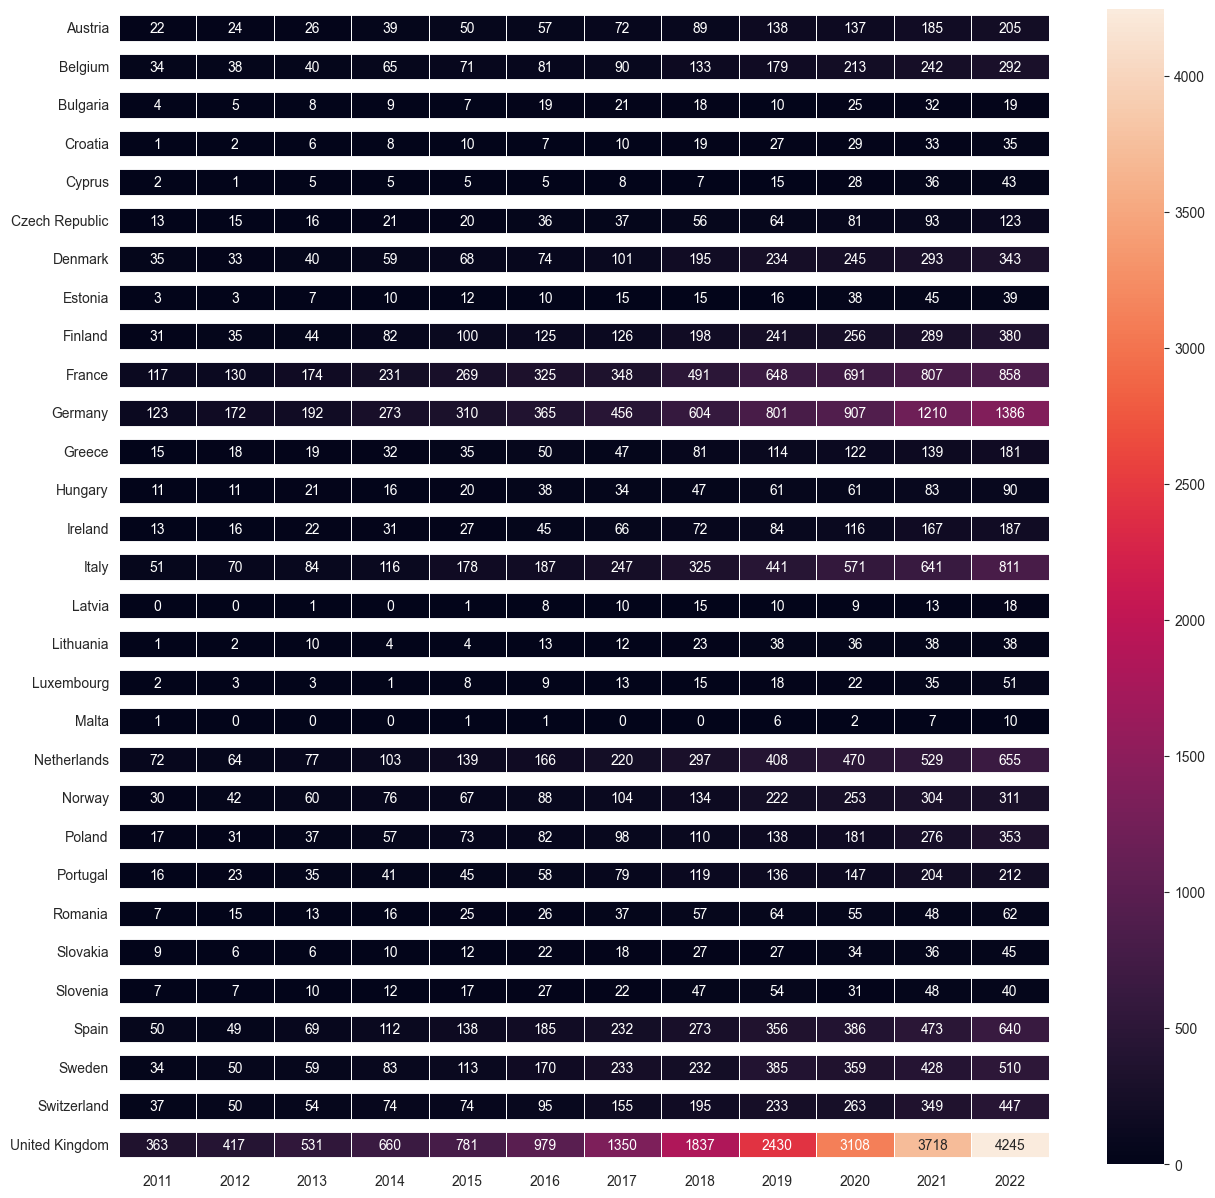

In [42]:
f, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(year_pivot, annot=True, fmt="d", linewidths=.5, ax=ax)
g.set(xlabel="", ylabel="")
for i in range(year_pivot.shape[0]+1):
    ax.axhline(i, color='white', lw=10)

In [43]:
year_percent_pivot = pd.crosstab(collab_year['Country'], collab_year['Publication Year'], values=collab_year[record_col], aggfunc='nunique', normalize='columns').fillna(0)*100
year_percent_pivot

Publication Year       2011       2012       2013       2014       2015   
Country                                                                   
Austria            1.962533   1.801802   1.557819   1.736420   1.865672  \
Belgium            3.033006   2.852853   2.396645   2.894034   2.649254   
Bulgaria           0.356824   0.375375   0.479329   0.400712   0.261194   
Croatia            0.089206   0.150150   0.359497   0.356189   0.373134   
Cyprus             0.178412   0.075075   0.299581   0.222618   0.186567   
Czech Republic     1.159679   1.126126   0.958658   0.934996   0.746269   
Denmark            3.122212   2.477477   2.396645   2.626892   2.537313   
Estonia            0.267618   0.225225   0.419413   0.445236   0.447761   
Finland            2.765388   2.627628   2.636309   3.650935   3.731343   
France            10.437110   9.759760  10.425404  10.284951  10.037313   
Germany           10.972346  12.912913  11.503895  12.154942  11.567164   
Greece             1.338091   1.351351   1.138406   1.424755   1.305970   
Hungary            0.981267   0.825826   1.258238   0.712378   0.746269   
Ireland            1.159679   1.201201   1.318155   1.380232   1.007463   
Italy              4.549509   5.255255   5.032954   5.164737   6.641791   
Latvia             0.000000   0.000000   0.059916   0.000000   0.037313   
Lithuania          0.089206   0.150150   0.599161   0.178094   0.149254   
Luxembourg         0.178412   0.225225   0.179748   0.044524   0.298507   
Malta              0.089206   0.000000   0.000000   0.000000   0.037313   
Netherlands        6.422837   4.804805   4.613541   4.585931   5.186567   
Norway             2.676182   3.153153   3.594967   3.383793   2.500000   
Poland             1.516503   2.327327   2.216896   2.537845   2.723881   
Portugal           1.427297   1.726727   2.097064   1.825467   1.679104   
Romania            0.624442   1.126126   0.778910   0.712378   0.932836   
Slovakia           0.802855   0.450450   0.359497   0.445236   0.447761   
Slovenia           0.624442   0.525526   0.599161   0.534283   0.634328   
Spain              4.460303   3.678679   4.134212   4.986643   5.149254   
Sweden             3.033006   3.753754   3.535051   3.695459   4.216418   
Switzerland        3.300624   3.753754   3.235470   3.294746   2.761194   
United Kingdom    32.381802  31.306306  31.815458  29.385574  29.141791   

Publication Year       2016       2017       2018       2019       2020   
Country                                                                   
Austria            1.699970   1.689744   1.552958   1.816267   1.543488  \
Belgium            2.415747   2.112180   2.320712   2.355883   2.399730   
Bulgaria           0.566657   0.492842   0.314081   0.131614   0.281658   
Croatia            0.208768   0.234687   0.331530   0.355357   0.326724   
Cyprus             0.149120   0.187749   0.122143   0.197420   0.315457   
Czech Republic     1.073665   0.868341   0.977142   0.842327   0.912573   
Denmark            2.206979   2.370336   3.402548   3.079758   2.760252   
Estonia            0.298240   0.352030   0.261734   0.210582   0.428121   
Finland            3.728005   2.957052   3.454894   3.171887   2.884182   
France             9.692812   8.167097   8.567440   8.528560   7.785038   
Germany           10.885774  10.701713  10.539173  10.542248  10.218567   
Greece             1.491202   1.103027   1.413366   1.500395   1.374493   
Hungary            1.133313   0.797935   0.820101   0.802843   0.687247   
Ireland            1.342082   1.548932   1.256325   1.105554   1.306895   
Italy              5.577095   5.796761   5.670913   5.804159   6.433078   
Latvia             0.238592   0.234687   0.261734   0.131614   0.101397   
Lithuania          0.387712   0.281624   0.401326   0.500132   0.405588   
Luxembourg         0.268416   0.305093   0.261734   0.236904   0.247859   
Malta              0.029824   0.000000   0.000000   0.078968   0.022533   
Netherlands        4.950

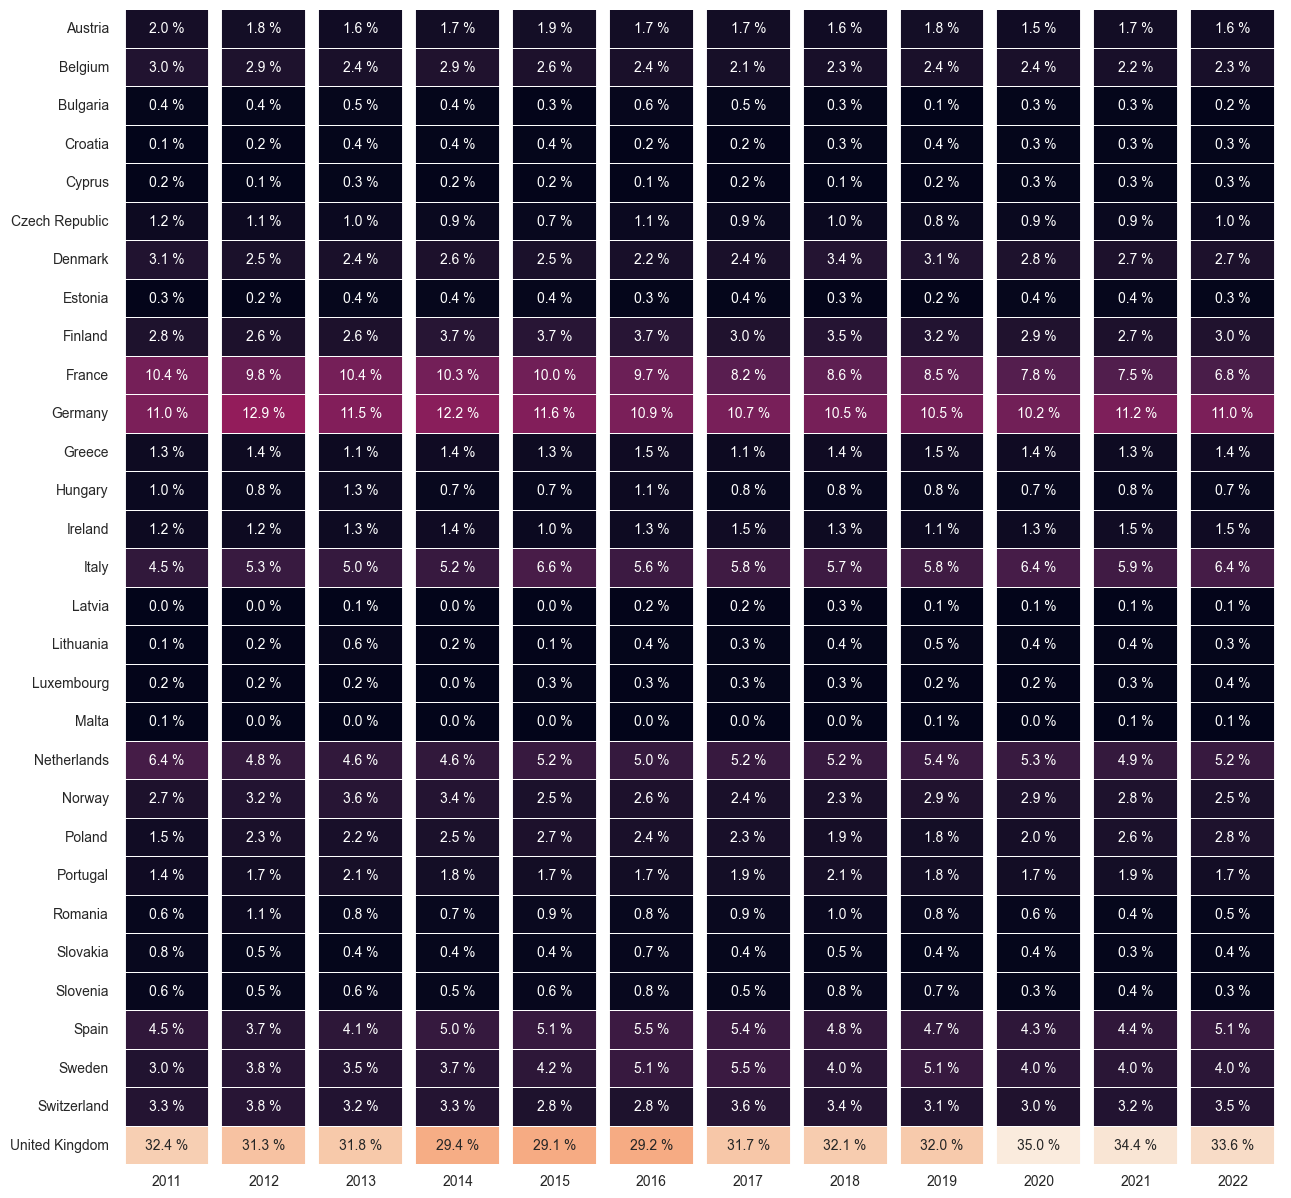

In [44]:
f, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(year_percent_pivot, annot=True, fmt='.1f', linewidths=(.5), ax=ax, cbar=False)
for t in ax.texts: t.set_text(t.get_text() + " %")
g.set(xlabel="", ylabel="")
for i in range(year_percent_pivot.shape[1]+1):
    ax.axvline(i, color='white', lw=10)

In [45]:
# Institutional collab

In [46]:
color_discrete_map= {'China': '#EF553B',
                    'EU': '#636EFA',
                    'Non-EU associate': '#00CC96'}

In [47]:
TOPN = 25


wos_univ_locations = wos_univ.merge(wos_country_types, on="Country")
wos_univ_collabs = wos_univ_locations[wos_univ_locations["Country_Type"]!="Other"][[record_col,"Country","Institution_harm","Country_Type","Eurovoc_Class"]].drop_duplicates()
wos_univ_collabs["ISO3"] = cc.pandas_convert(series=wos_univ_collabs["Country"], to='ISO3')
wos_univ_collabs["Institution_harm_label"] = wos_univ_collabs["Institution_harm"] + " ("+wos_univ_collabs["ISO3"]+ ")"


wos_univ_ch = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="China"]
wos_univ_eu = wos_univ_collabs[wos_univ_collabs["Country_Type"]!="China"]

wos_univ_eu_strict = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="EU"]

data_eu = (wos_univ_eu.groupby(["Country","Institution_harm_label","Country_Type"], as_index=False)[record_col].nunique()
           .sort_values(by=record_col,ascending=False).head(TOPN).copy()).sort_values(by="Country_Type")

data_eu_strict = (wos_univ_eu_strict.groupby(["Country","Institution_harm_label","Eurovoc_Class"], as_index=False)[record_col].nunique()
           .sort_values(by=record_col,ascending=False).head(TOPN).copy())

data_ch = (wos_univ_ch.groupby(["Country","Institution_harm","Country_Type"], as_index=False)[record_col].nunique()
           .sort_values(by=record_col,ascending=False).head(TOPN).copy())


for data,c_scope, y_lab, col_by, pat in zip([data_eu,data_eu_strict,data_ch],
                        ["European countries in scope","EU-28 only","China"],
                        ["Institution_harm_label","Institution_harm_label","Institution_harm"],
                        ["Country","Eurovoc_Class","Country_Type"],
                                       ["Country_Type",None,None]):
    fig = px.bar(data, x=record_col, y=y_lab, color=col_by, color_discrete_map=color_discrete_map,pattern_shape=pat,
                              labels={
                     record_col: 'Number of co-publications',
                     "Institution_harm": "Institution",
                                  "Institution_harm_label": "Institution",
                                  "Country_Type":"Country type",
                                  "Eurovoc_Class":"Region"
                 },
                title=f"Most visible institutions (top {TOPN} within {c_scope})", template='plotly')
    fig.update_layout(xaxis_tickformat='d',font_family="Montserrat",yaxis={'categoryorder':'total ascending'},
                                         width=1000, height=1000,)
    fig.update_traces(hovertemplate='%{x:d}')
    fig.add_shape(
            # Rectangle with reference to the plot
                type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
                line=dict(
                    color="black",
                     width=0.5,
                 )
             )
    fig.update_yaxes(
        showgrid=True,
        ticks="outside")
    fig.update_xaxes(
        showgrid=True,
        ticks="outside")
    # fig.show(config= dict(displayModeBar = False))
    fig.write_html(f"plot_html/overall_inst_collab_bar_{c_scope}.html",config= dict(displayModeBar = False, responsive = True))

In [48]:
wos_univ_ch = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="China"]
wos_univ_eu = wos_univ_collabs[wos_univ_collabs["Country_Type"]!="China"]

wos_univ_dipol = wos_univ_eu.merge(wos_univ_ch, on=record_col, suffixes=('_eu', '_ch')).merge(wos[[record_col,"Domain_English","Field_English","SubField_English"]], on =record_col)

In [49]:
fig = px.parallel_categories(wos_univ_dipol[["Country_eu","Domain_English","Country_ch"]])

In [50]:
data_ch.columns

Index(['Country', 'Institution_harm', 'Country_Type', 'UT (Unique WOS ID)'], dtype='object')

In [51]:
subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu["Institution_harm_label"]))&
             (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Domain_English","Country_ch"]])
# fig.show()

In [52]:
subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu["Institution_harm_label"]))&
             (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Institution_harm_eu","Domain_English","Institution_harm_ch"]])
# fig.show()
sub_df =wos_univ_dipol[subfilter]

inst_co_occur = pd.crosstab(sub_df['Institution_harm_label_eu'], sub_df['Institution_harm_ch'],
                            values=sub_df[record_col], aggfunc='nunique').fillna(0).astype(int)

eu_list = sub_df.groupby(['Institution_harm_label_eu'])[record_col].count().sort_values(ascending=False).index
ch_list = sub_df.groupby(['Institution_harm_ch'])[record_col].count().sort_values(ascending=False).index

inst_co_occur = inst_co_occur.reindex(index = eu_list, columns=ch_list)

mask = np.triu(np.ones_like(inst_co_occur, dtype=bool))
data = np.where(mask,inst_co_occur,inst_co_occur)

fig = px.imshow(data,
                labels=dict(x="Institute (CH)", y="Institute (EU)", color="Co-publication"),
                x=list(inst_co_occur.columns),
                y=list(inst_co_occur.index), title=f"Most visible institutions (top {TOPN} within Europe)"
               )
fig.update_layout(title_x=0.5,
                   width=1000, height=1000,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed',
                  template='plotly_white',
                  coloraxis_colorbar=dict(
                            thicknessmode="pixels", thickness=25,
                            ticks="outside", ticksuffix=" ",
                            dtick=20,outlinewidth=1,
                        ))
fig.update_xaxes(tickangle= -45)
fig.update_yaxes(
    ticks="outside")
fig.update_xaxes(
    ticks="outside")

fig.write_html(f"plot_html/overall_inst_collab_europe.html",config= dict(displayModeBar = False, responsive = True))

In [53]:
subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu_strict["Institution_harm_label"]))&
             (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Institution_harm_eu","Domain_English","Institution_harm_ch"]])
# fig.show()
sub_df =wos_univ_dipol[subfilter]

inst_co_occur = pd.crosstab(sub_df['Institution_harm_label_eu'], sub_df['Institution_harm_ch'],
                            values=sub_df[record_col], aggfunc='nunique').fillna(0).astype(int)

eu_list = sub_df.groupby(['Institution_harm_label_eu'])[record_col].count().sort_values(ascending=False).index
ch_list = sub_df.groupby(['Institution_harm_ch'])[record_col].count().sort_values(ascending=False).index

inst_co_occur = inst_co_occur.reindex(index = eu_list, columns=ch_list)

mask = np.triu(np.ones_like(inst_co_occur, dtype=bool))
data = np.where(mask,inst_co_occur,inst_co_occur)
fig = px.imshow(data,
                labels=dict(x="Institute (CH)", y="Institute (EU)", color="Co-publication"),
                x=list(inst_co_occur.columns),
                y=list(inst_co_occur.index), title=f"Most visible institutions (top {TOPN} within EU-28)"
               )
fig.update_layout(title_x=0.5,
                   width=1000, height=1000,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed',
                  template='plotly_white',
                  coloraxis_colorbar=dict(
                            thicknessmode="pixels", thickness=25,
                            ticks="outside", ticksuffix=" ",
                            dtick=20,outlinewidth=1,
                        ))
fig.update_xaxes(tickangle= -45)
fig.update_yaxes(
    ticks="outside")
fig.update_xaxes(
    ticks="outside")

# fig.show(config= dict(displayModeBar = False))
fig.write_html(f"plot_html/overall_inst_collab_eu28.html",config= dict(displayModeBar = False, responsive = True))

# Drilldown to field

In [54]:
group = ['Publication Year',"Domain_English",'Field_English']
# data = wos.groupby(['Publication Year',"Domain_English",'Field_English'], as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])


data = (wos.groupby(['Publication Year','Field_English'],)[record_col].nunique(dropna=False).unstack()
        .fillna(0)
        .stack()
        .reset_index()
        .rename(columns={0:record_col}))

data = data.merge(wos[["Domain_English",'Field_English']].drop_duplicates(),on="Field_English")

data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset='Field_English'),
                  on='Field_English', suffixes=[None,"_relative_growth"])
data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]

data = data.sort_values(by =["Field_English","Publication Year"], ascending=[True,True])
data[record_col+"_cumsum"] = (data.groupby('Field_English',as_index=False)[record_col].cumsum())

In [55]:
data[data["Domain_English"]=="Applied Sciences"]

Publication Year                      Field_English  UT (Unique WOS ID)   
0                2011  Agriculture, Fisheries & Forestry                 9.0  \
1                2012  Agriculture, Fisheries & Forestry                18.0   
2                2013  Agriculture, Fisheries & Forestry                15.0   
3                2014  Agriculture, Fisheries & Forestry                26.0   
4                2015  Agriculture, Fisheries & Forestry                12.0   
..                ...                                ...                 ...   
255              2018                    Social Sciences                25.0   
257              2019                    Social Sciences                37.0   
259              2020                    Social Sciences                57.0   
261              2021                    Social Sciences                65.0   
263              2022                    Social Sciences                60.0   

       Domain_English  Publication Year_relative_growth   
0    Applied Sciences                              2011  \
1    Applied Sciences                              2011   
2    Applied Sciences                              2011   
3    Applied Sciences                              2011   
4    Applied Sciences                              2011   
..                ...                               ...   
255  Applied Sciences                              2011   
257  Applied Sciences                              2011   
259  Applied Sciences                              2011   
261  Applied Sciences                              2011   
263  Applied Sciences                              2011   

     UT (Unique WOS ID)_relative_growth Domain_English_relative_growth   
0                              0.000000               Applied Sciences  \
1                              1.000000               Applied Sciences   
2                              0.666667               Applied Sciences   
3                              1.888889               Applied Sciences   
4                              0.333333               Applied Sciences   
..                                  ...                            ...   
255                            1.272727               Applied Sciences   
257                            2.363636               Applied Sciences   
259                            4.181818               Applied Sciences   
261                            4.909091               Applied Sciences   
263                            4.454545               Applied Sciences   

     UT (Unique WOS ID)_cumsum  
0                          9.0  
1                         27.0  
2                         42.0  
3                         68.0  
4                         80.0  
..                         ...  
255                      216.0  
257                      290.0  
259                      404.0  
261                      534.0  
263                      654.0  

[84 rows x 8 columns]

In [56]:
wos[wos["Domain_English"]=="Applied Sciences"].groupby("Field_English", as_index=False)[record_col].nunique().sort_values(ascending=False, by=record_col)

Field_English  UT (Unique WOS ID)
5  Information & Communication Technologies               15648
4                               Engineering                9232
3         Enabling & Strategic Technologies                3940
0         Agriculture, Fisheries & Forestry                 612
1                Built Environment & Design                 537
2                     Economics & Business                   15
6                           Social Sciences                   1

In [59]:
group = ['Publication Year',"Domain_English",'Field_English']
# data = wos.groupby(['Publication Year',"Domain_English",'Field_English'], as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
data_complete = pd.DataFrame()

for cat in sorted(wos["Domain_English"].unique()):

    os.makedirs(rf'plot_html/{cat}',exist_ok=True)
    id_subset = wos[wos["Domain_English"]==cat][record_col].unique()

    data = (wos.groupby(['Publication Year','Field_English'],)[record_col].nunique(dropna=False).unstack()
        .fillna(0)
        .stack()
        .reset_index()
        .rename(columns={0:record_col}))

    data = data.merge(wos[["Domain_English",'Field_English']].drop_duplicates(),on="Field_English")

    data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset='Field_English'),
                      on='Field_English', suffixes=[None,"_relative_growth"])
    data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]

    data = data.sort_values(by =["Field_English","Publication Year"], ascending=[True,True])
    data[record_col+"_cumsum"] = (data.groupby('Field_English',as_index=False)[record_col].cumsum())



    bar_data = wos[wos["Domain_English"]==cat].groupby("Field_English", as_index=False)[record_col].nunique().sort_values(ascending=False, by=record_col)

    fig = px.bar(bar_data.sort_values(by="Field_English"), x=record_col, y="Field_English", color="Field_English",barmode='relative',
                                  labels={
                         record_col: 'Number of co-publications',
                     },
                    title="Distribution of Domains", template='plotly')
    fig.update_layout(showlegend=False, xaxis_tickformat='d',font_family="Montserrat")
    fig.update_traces(hovertemplate='%{x:d}')
    fig.add_shape(
            # Rectangle with reference to the plot
                type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
                line=dict(
                    color="black",
                     width=0.5,
                 )
             )
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.update_yaxes(
        showgrid=True,
        ticks="outside")
    fig.update_xaxes(
        showgrid=True,
        ticks="outside")
    dom_distr = go.Figure(fig)


    #data segment
    sub_data = data[data["Domain_English"]==cat]
    # data_complete = pd.concat([data_complete,sub_data], ignore_index=True)
    fig = px.line(sub_data.sort_values(ascending=[True,True], by=["Publication Year","Field_English"]),y=record_col,x="Publication Year", color="Field_English", markers=True,
                  labels={
                     record_col: 'Number of co-publications',
                     group[-1]: "Domain",
                 },
                title="Yearly output of co-publications", template='plotly')
    fig.update_traces(hovertemplate='%{y:d}')
    fig.update_layout(hovermode='x unified')
    fig.add_shape(
            # Rectangle with reference to the plot
                type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
                line=dict(
                    color="black",
                     width=0.5,
                 )
             )
    fig.update_yaxes(
        showgrid=True,
        ticks="outside")
    fig.update_xaxes(
        showgrid=True,
        ticks="outside")

    year_output_by_domain = go.Figure(fig)

    fig = px.line(sub_data.sort_values(ascending=[True,True], by=["Publication Year","Field_English"]), y=record_col+"_relative_growth",x="Publication Year", color="Field_English",
                  markers=True,labels={
                         record_col+"_relative_growth": 'Rel. growth<br>in co-publications (%)',
                         group[-1]: "Domain",
                     },
                    title="Relative growth in the output of co-publications", template='plotly')
    # fig.update_traces(hovertemplate='%{y:.2f}%')

    fig.update_layout(hovermode='x unified',yaxis_tickformat='.0f%',font_family="Montserrat")
    fig.update_traces(hovertemplate='%{y:.0f}00%')
    fig.add_shape(
            # Rectangle with reference to the plot
                type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
                line=dict(
                    color="black",
                     width=0.5,
                 )
             )
    fig.update_yaxes(
        showgrid=True,
        ticks="outside")
    fig.update_xaxes(
        showgrid=True,
        ticks="outside")
    # fig['layout']['yaxis4'].update(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')
    # fig.update_yaxes(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')

    rel_output_by_domain = go.Figure(fig)

    fig = px.area(sub_data.sort_values(ascending=[True,True], by=["Publication Year","Field_English"]),y=record_col+"_cumsum",x="Publication Year", color="Field_English",line_group="Field_English",
                  labels={
                         record_col+"_cumsum": 'Cumulative number of co-publications',
                     },
                    title="Cumulative number of co-publications", template='plotly')
    fig.update_traces(hovertemplate='%{y:d}')
    fig.update_layout(hovermode='x unified')
    fig.add_shape(
            # Rectangle with reference to the plot
                type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
                line=dict(
                    color="black",
                     width=0.5,
                 )
             )
    fig.update_yaxes(
        showgrid=True,
        ticks="outside")
    fig.update_xaxes(
        showgrid=True,
        ticks="outside")

    cumsum_by_domain = go.Figure(fig)
    # cumsum_by_domain.show(config= dict(displayModeBar = False))

    # dom_distr
    # year_output_by_domain
    # rel_output_by_domain
    # cumsum_by_domain

    figsuper = make_subplots(rows=2, cols=2, subplot_titles=["Distribution of domains","Cumulative sum of co-publications",
                                                             "Co-publications per year","Relative growth of co-publications"])


    for trace in list(dom_distr.select_traces()):
        trace.showlegend=False
        # trace.barmode
        figsuper.add_trace(trace,
            row=1, col=1
        )

    for trace in list(cumsum_by_domain.select_traces()):
        figsuper.add_trace(trace,
            row=1, col=2
        )

    for trace in list(year_output_by_domain.select_traces()):
        trace.showlegend=False
        figsuper.add_trace(trace,
            row=2, col=1
        )

    for trace in list(rel_output_by_domain.select_traces()):
        trace.showlegend=False
        figsuper.add_trace(trace,
            row=2, col=2
        )

    # figsuper.update_layout(hovermode='x unified')
    figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative')
    figsuper.update_yaxes(
        showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
        ticks="outside")
    figsuper.update_xaxes(
        showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
        ticks="outside")
    figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
    figsuper['layout']['yaxis4'].update(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey',tickformat=".0%")
    # figsuper.layout.annotations[0].update(x=0.1)
    # figsuper.layout.annotations[2].update(x=0.105)
    # figsuper.layout.annotations[1].update(x=0.7)
    # figsuper.layout.annotations[3].update(x=0.7)
    figsuper.update_layout(title_text=f"{cat}")

    # figsuper.show(config= dict(displayModeBar = False, responsive = True))
    figsuper.write_html(f"plot_html/{cat}/{cat}_distr&trends.html",config= dict(displayModeBar = False, responsive = True))


    # country contributions
    wos_univ_locations = wos_univ[wos_univ[record_col].isin(id_subset)].merge(wos_country_types, on="Country")
    wos_collabs = wos_univ_locations[wos_univ_locations["Country_Type"]!="Other"][[record_col,"Country"]].drop_duplicates()

    collab_desc = wos_collabs[wos_collabs["Country"]!="China"]["Country"].value_counts().reset_index()
    collab_desc["percent_of_copubs"] = collab_desc["count"]/wos_collabs[record_col].nunique()#*100
    collab_desc["percent_contrib_in_copubs"] = collab_desc["count"]/wos_collabs[record_col].size#*100
    collab_desc = collab_desc.merge(wos_country_types, on="Country")
    # collab_desc

    c_dict = {"count":"Number of co-publications",
              "percent_of_copubs":"Percent of co-publications",
              "percent_contrib_in_copubs":"Contribution to co-publications"}

    color_discrete_map= {'China': '#EF553B',
                        'EU': '#636EFA',
                        'Non-EU associate': '#00CC96'}

    fig_dict = dict()
    for c in c_dict.keys():
        data = collab_desc[["Country",c,"Country_Type"]]
        # plt.figure(figsize=(9,12))
        col_by="Country_Type"
        y_lab="Country"
        fig = px.bar(data, x=c, y=y_lab, color=col_by, color_discrete_map=color_discrete_map,
                                  labels=dict({
                         record_col: 'Number of co-publications',
                         "Institution_harm": "Institution",
                                      "Institution_harm_label": "Institution",
                                      "Country_Type":"Country type",
                                      "Eurovoc_Class":"Region"
                     },**c_dict),
                    title=c_dict[c], template='plotly')
        fig.update_layout(xaxis_tickformat='d',font_family="Montserrat",
                          yaxis={'categoryorder':'total ascending'},
                                             width=1000, height=1000,)
        if "percent" in c:
            fig.update_traces(hovertemplate='%{y}<br>%{x}')
            fig.update_xaxes(tickformat=".1%")
        else:
            fig.update_traces(hovertemplate='%{y}<br>%{x:d}')
        fig_dict[c] = go.Figure(fig)

    figsuper = make_subplots(rows=1, cols=3, subplot_titles =list(c_dict.values()))
    for i,f in enumerate(fig_dict.keys()):
        sfig = fig_dict[f]
        for trace in list(sfig.select_traces()):
            trace.showlegend=False
            figsuper.add_trace(trace,
                row=1, col=i+1)

    figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative',yaxis2={'categoryorder':'total ascending'},yaxis3={'categoryorder':'total ascending'})
    figsuper.update_yaxes(
        showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
        ticks="outside")
    figsuper.update_xaxes(
        showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
        ticks="outside")
    figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
    # figsuper.show(config= dict(displayModeBar = False, responsive = True))
    figsuper.write_html(f"plot_html/{cat}/{cat}_europe_contribution_bar.html",config= dict(displayModeBar = False, responsive = True))


    # intraeurope collabs
    wos_collabs_EU = wos_univ_locations[~wos_univ_locations["Country_Type"].isin(["Other","China"])][[record_col,"Country"]].drop_duplicates()
    wos_collabs_EU = wos_collabs_EU.merge(wos_collabs_EU, on=record_col)
    EU_co_occur = pd.crosstab(wos_collabs_EU['Country_x'], wos_collabs_EU['Country_y'], values=wos_collabs_EU[record_col], aggfunc='nunique').fillna(0).astype(int)


    eu_list = wos_collabs_EU.groupby(['Country_x'])[record_col].count().sort_values(ascending=False).index

    EU_co_occur = EU_co_occur.reindex(index = eu_list, columns=eu_list)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(EU_co_occur, dtype=bool))
    data = np.where(mask,None,EU_co_occur)

    fig = px.imshow(data,
                    labels=dict(x="Country", y="Country", color="Co-publication with China"),
                    x=list(EU_co_occur.columns),
                    y=list(EU_co_occur.index), title="Intraeuropean patterns<br>Co-occurences of countries in chinese co-publications"
                   )
    fig.update_layout(title_x=0.5,
                       width=1000, height=1000,
                       xaxis_showgrid=False,
                       yaxis_showgrid=False,
                       yaxis_autorange='reversed', template='plotly_white')
    # fig.update_traces(hovertemplate='<b>%{y}</b><br>%{x}<br>Co-publications: %{hovertext}')
    fig.update_xaxes(tickangle= -90)
    fig.update_yaxes(
        ticks="outside")
    fig.update_xaxes(
        ticks="outside")
    # fig.show(config= dict(displayModeBar = False,responsive=True))
    fig.write_html(f"plot_html/{cat}/{cat}_intraeurope_collabs.html",config= dict(displayModeBar = False, responsive = True))

    # country trends
    collab_year = wos_collabs[wos_collabs["Country"]!="China"].copy()
    collab_year = collab_year.merge(wos_country_types, on="Country").merge(wos[[record_col,"Publication Year"]],on=record_col).drop_duplicates()

    data = (collab_year.groupby(['Publication Year',"Country"])[record_col]
            .nunique(dropna=False).unstack()
            .fillna(0)
            .stack()
            .reset_index()
            .rename(columns={0:record_col}))
    data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset="Country"),
                      on=["Country"], suffixes=[None,"_relative_growth"])
    data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]*100
    data = data.sort_values(by =["Country","Publication Year"], ascending=[True,True])
    data[record_col+"_cumsum"] = (data.groupby('Country',as_index=False)[record_col].cumsum())
    data = data.merge(wos_country_types, on='Country')
    # data

    data["ISO3"] = cc.pandas_convert(series=data["Country"], to='ISO3')
    fig = px.choropleth(data[data["Publication Year"] == 2022], locations="ISO3", color=record_col+"_cumsum", hover_name="Country",
                        scope="europe", template='plotly',
                        range_color=[data[record_col+"_cumsum"].min(),data[record_col+"_cumsum"].max()],hover_data=["Eurovoc_Class"])
    # original: '<b>%{hovertext}</b><br><br>ISO3=%{location}<br>Eurovoc_Class=%{customdata[0]}<br>UT (Unique WOS ID)_cumsum=%{z}<extra></extra>'

    fig.update_traces(hovertemplate='<b>%{hovertext}</b>'
                                    '<br>Region: %{customdata[0]}<br>'
                                    'Co-pubications: %{z:d}<extra></extra>')

    cumsum_country = go.Figure(fig)

    figsuper = make_subplots(rows=3, cols=2, subplot_titles=["Number of publications (2022)","Cumulative number of co-publications",
                                                         "Yearly output of co-publications","Relative growth of co-publications"],
                         specs=[
                            [{"type": "geo", "rowspan":3}, {"type": "xy"}],
                            [None,{"type": "xy"}],
                            [None, {"type": "xy"}]
                         ])

    for trace in list(cumsum_country.select_traces()):
        figsuper.add_trace(trace,
            row=1, col=1
        )

    fig = px.area(data.sort_values(ascending=True, by='Publication Year'),  y=record_col+"_cumsum",
                  x='Publication Year',
                  color="Eurovoc_Class",
                  line_group="Country",
                  labels={
                         record_col: 'Number of co-publications',
                      "Eurovoc_Class": "Region"
                     },
                    title="Cumulative number of co-publications",
                  hover_name= "Country")
    fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')

    for trace in list(fig.select_traces()):
        figsuper.add_trace(trace,
            row=1, col=2
        )


    fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
                  y=record_col,
                  x='Publication Year',
                  color="Eurovoc_Class",
                  line_group="Country",
                  markers=True,
                  labels={
                         record_col: 'Number of co-publications',
                      "Eurovoc_Class": "Region"
                     },
                    title="Yearly output of co-publications",hover_name= "Country")
    fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')

    for trace in list(fig.select_traces()):
        trace.showlegend=False
        figsuper.add_trace(trace,
            row=2, col=2
        )

    fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
                  y=record_col+"_relative_growth",
                  x='Publication Year',
                  color="Eurovoc_Class",line_group="Country",markers=True,
                  labels={
                         record_col+"_relative_growth": 'Relative growth of co-publications (%)',"Eurovoc_Class": "Region"
                     },
                    title="Relative growth of co-publications", template='plotly',hover_name= "Country")
    fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Relative growth: %{y}%')
    fig.add_shape(
            # Rectangle with reference to the plot
                type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
                line=dict(
                    color="black",
                     width=0.5,
                 )
             )

    for trace in list(fig.select_traces()):
        trace.showlegend=False
        figsuper.add_trace(trace,
            row=3, col=2
        )

    figsuper.update_yaxes(
        showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
        ticks="outside")
    figsuper.update_xaxes(
        showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
        ticks="outside")
    figsuper.update_layout({'template':"plotly"})
    figsuper.layout["geo"]["scope"] = 'europe'
    figsuper.update_coloraxes(colorbar=dict(lenmode='fraction',len=0.55, orientation="v",yanchor='top', title="Co-publications",
                                            ticks="outside", ticksuffix=" ",outlinewidth=0.5))
    # figsuper.show(config= dict(displayModeBar = False, responsive = True))
    figsuper.write_html(f"plot_html/{cat}/{cat}_country_trends_overall.html",config= dict(displayModeBar = False, responsive = True))


    TOPN = 25
    wos_univ_locations = wos_univ[wos_univ[record_col].isin(id_subset)].merge(wos_country_types, on="Country")
    wos_univ_collabs = wos_univ_locations[wos_univ_locations["Country_Type"]!="Other"][[record_col,"Country","Institution_harm","Country_Type","Eurovoc_Class"]].drop_duplicates()
    wos_univ_collabs["ISO3"] = cc.pandas_convert(series=wos_univ_collabs["Country"], to='ISO3')
    wos_univ_collabs["Institution_harm_label"] = wos_univ_collabs["Institution_harm"] + " ("+wos_univ_collabs["ISO3"]+ ")"


    wos_univ_ch = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="China"]
    wos_univ_eu = wos_univ_collabs[wos_univ_collabs["Country_Type"]!="China"]

    wos_univ_eu_strict = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="EU"]

    data_eu = (wos_univ_eu.groupby(["Country","Institution_harm_label","Country_Type"], as_index=False)[record_col].nunique()
               .sort_values(by=record_col,ascending=False).head(TOPN).copy()).sort_values(by="Country_Type")

    data_eu_strict = (wos_univ_eu_strict.groupby(["Country","Institution_harm_label","Eurovoc_Class"], as_index=False)[record_col].nunique()
               .sort_values(by=record_col,ascending=False).head(TOPN).copy())

    data_ch = (wos_univ_ch.groupby(["Country","Institution_harm","Country_Type"], as_index=False)[record_col].nunique()
               .sort_values(by=record_col,ascending=False).head(TOPN).copy())


    for data,c_scope, y_lab, col_by, pat in zip([data_eu,data_eu_strict,data_ch],
                            ["European countries in scope","EU-28 only","China"],
                            ["Institution_harm_label","Institution_harm_label","Institution_harm"],
                            ["Country","Eurovoc_Class","Country_Type"],
                                           ["Country_Type",None,None]):
        fig = px.bar(data, x=record_col, y=y_lab, color=col_by, color_discrete_map=color_discrete_map,pattern_shape=pat,
                                  labels={
                         record_col: 'Number of co-publications',
                         "Institution_harm": "Institution",
                                      "Institution_harm_label": "Institution",
                                      "Country_Type":"Country type",
                                      "Eurovoc_Class":"Region"
                     },
                    title=f"Most visible institutions (top {TOPN} within {c_scope})", template='plotly')
        fig.update_layout(xaxis_tickformat='d',font_family="Montserrat",yaxis={'categoryorder':'total ascending'},
                                             width=1000, height=1000,)
        fig.update_traces(hovertemplate='%{x:d}')
        fig.add_shape(
                # Rectangle with reference to the plot
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
                    line=dict(
                        color="black",
                         width=0.5,
                     )
                 )
        fig.update_yaxes(
            showgrid=True,
            ticks="outside")
        fig.update_xaxes(
            showgrid=True,
            ticks="outside")
        # fig.show(config= dict(displayModeBar = False))
        fig.write_html(f"plot_html/{cat}/{cat}_overall_inst_collab_bar_{c_scope}.html",config= dict(displayModeBar = False, responsive = True))
    wos_univ_ch = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="China"]
    wos_univ_eu = wos_univ_collabs[wos_univ_collabs["Country_Type"]!="China"]

    wos_univ_dipol = wos_univ_eu.merge(wos_univ_ch, on=record_col, suffixes=('_eu', '_ch')).merge(wos[[record_col,"Domain_English","Field_English","SubField_English"]], on =record_col)

    subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu["Institution_harm_label"]))&
             (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

    fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Institution_harm_eu","Domain_English","Institution_harm_ch"]])
    # fig.show()
    sub_df = wos_univ_dipol[subfilter]

    inst_co_occur = pd.crosstab(sub_df['Institution_harm_label_eu'], sub_df['Institution_harm_ch'],
                                values=sub_df[record_col], aggfunc='nunique').fillna(0).astype(int)

    eu_list = sub_df.groupby(['Institution_harm_label_eu'])[record_col].count().sort_values(ascending=False).index
    ch_list = sub_df.groupby(['Institution_harm_ch'])[record_col].count().sort_values(ascending=False).index

    inst_co_occur = inst_co_occur.reindex(index = eu_list, columns=ch_list)

    mask = np.triu(np.ones_like(inst_co_occur, dtype=bool))
    data = np.where(mask,inst_co_occur,inst_co_occur)

    fig = px.imshow(data,
                    labels=dict(x="Institute (CH)", y="Institute (EU)", color="Co-publication"),
                    x=list(inst_co_occur.columns),
                    y=list(inst_co_occur.index), title=f"Most visible institutions (top {TOPN} within Europe)"
                   )
    fig.update_layout(title_x=0.5,
                       width=1000, height=1000,
                       xaxis_showgrid=False,
                       yaxis_showgrid=False,
                       yaxis_autorange='reversed',
                      template='plotly_white',
                      coloraxis_colorbar=dict(
                                thicknessmode="pixels", thickness=25,
                                ticks="outside", ticksuffix=" ",
                                dtick=20,outlinewidth=1,
                            ))
    fig.update_xaxes(tickangle= -45)
    fig.update_yaxes(
        ticks="outside")
    fig.update_xaxes(
        ticks="outside")

    fig.write_html(f"plot_html/{cat}/{cat}_overall_inst_collab_europe.html",config= dict(displayModeBar = False, responsive = True))



    subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu_strict["Institution_harm_label"]))&
             (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

    fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Institution_harm_eu","Domain_English","Institution_harm_ch"]])
    # fig.show()
    sub_df =wos_univ_dipol[subfilter]

    inst_co_occur = pd.crosstab(sub_df['Institution_harm_label_eu'], sub_df['Institution_harm_ch'],
                                values=sub_df[record_col], aggfunc='nunique').fillna(0).astype(int)

    eu_list = sub_df.groupby(['Institution_harm_label_eu'])[record_col].count().sort_values(ascending=False).index
    ch_list = sub_df.groupby(['Institution_harm_ch'])[record_col].count().sort_values(ascending=False).index

    inst_co_occur = inst_co_occur.reindex(index = eu_list, columns=ch_list)

    mask = np.triu(np.ones_like(inst_co_occur, dtype=bool))
    data = np.where(mask,inst_co_occur,inst_co_occur)
    fig = px.imshow(data,
                    labels=dict(x="Institute (CH)", y="Institute (EU)", color="Co-publication"),
                    x=list(inst_co_occur.columns),
                    y=list(inst_co_occur.index), title=f"Most visible institutions (top {TOPN} within EU-28)"
                   )
    fig.update_layout(title_x=0.5,
                       width=1000, height=1000,
                       xaxis_showgrid=False,
                       yaxis_showgrid=False,
                       yaxis_autorange='reversed',
                      template='plotly_white',
                      coloraxis_colorbar=dict(
                                thicknessmode="pixels", thickness=25,
                                ticks="outside", ticksuffix=" ",
                                dtick=20,outlinewidth=1,
                            ))
    fig.update_xaxes(tickangle= -45)
    fig.update_yaxes(
        ticks="outside")
    fig.update_xaxes(
        ticks="outside")

    # fig.show(config= dict(displayModeBar = False))
    fig.write_html(f"plot_html/{cat}/{cat}_overall_inst_collab_eu28.html",config= dict(displayModeBar = False, responsive = True))

In [ ]:
# Drill down to subfield

In [63]:
group = ['Publication Year',"Domain_English",'Field_English']
# data = wos.groupby(['Publication Year',"Domain_English",'Field_English'], as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
data_complete = pd.DataFrame()

colt=["Domain_English",'Field_English','SubField_English']

for c in colt:
    wos[c] = wos[c].str.strip()

for cat in sorted(wos["Domain_English"].unique()):
    os.makedirs(rf'plot_html/{cat}',exist_ok=True)
    wos_sub = wos[wos["Domain_English"]==cat]

    for cat2 in sorted(wos_sub["Field_English"].unique()):
        os.makedirs(rf'plot_html/{cat}/{cat2}',exist_ok=True)

        id_subset = wos[((wos["Domain_English"]==cat)&
                         (wos["Field_English"]==cat2))][record_col].unique()

        data = (wos[wos[record_col].isin(id_subset)]
                .groupby(['Publication Year','SubField_English'],)[record_col].nunique(dropna=False).unstack()
            .fillna(0)
            .stack()
            .reset_index()
            .rename(columns={0:record_col}))

        data = data.merge(wos_sub[["Field_English",'SubField_English']]
                          .drop_duplicates(),on="SubField_English")

        data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset='SubField_English'),
                          on='SubField_English', suffixes=[None,"_relative_growth"])
        data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]

        data = data.sort_values(by =["SubField_English","Publication Year"], ascending=[True,True])
        data[record_col+"_cumsum"] = (data.groupby('SubField_English',as_index=False)[record_col].cumsum())



        bar_data = (wos[((wos["Domain_English"]==cat)&
                        (wos["Field_English"]==cat2))]
                    .groupby("SubField_English", as_index=False)[record_col]
                    .nunique()
                    .sort_values(ascending=False, by=record_col))

        fig = px.bar(bar_data.sort_values(by="SubField_English"),
                     x=record_col, y="SubField_English", color="SubField_English",barmode='relative',
                                      labels={
                             record_col: 'Number of co-publications',
                         },
                        title="Distribution of Domains", template='plotly')
        fig.update_layout(showlegend=False, xaxis_tickformat='d',font_family="Montserrat")
        fig.update_traces(hovertemplate='%{x:d}')
        fig.add_shape(
                # Rectangle with reference to the plot
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
                    line=dict(
                        color="black",
                         width=0.5,
                     )
                 )
        fig.update_layout(yaxis={'categoryorder':'total ascending'})
        fig.update_yaxes(
            showgrid=True,
            ticks="outside")
        fig.update_xaxes(
            showgrid=True,
            ticks="outside")
        dom_distr = go.Figure(fig)


        #data segment
        sub_data = data[data["Field_English"]==cat2]
        # data_complete = pd.concat([data_complete,sub_data], ignore_index=True)
        fig = px.line(sub_data.sort_values(ascending=[True,True], by=["Publication Year","SubField_English"]),y=record_col,x="Publication Year", color="SubField_English", markers=True,
                      labels={
                         record_col: 'Number of co-publications',
                         group[-1]: "Domain",
                     },
                    title="Yearly output of co-publications", template='plotly')
        fig.update_traces(hovertemplate='%{y:d}')
        fig.update_layout(hovermode='x unified')
        fig.add_shape(
                # Rectangle with reference to the plot
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
                    line=dict(
                        color="black",
                         width=0.5,
                     )
                 )
        fig.update_yaxes(
            showgrid=True,
            ticks="outside")
        fig.update_xaxes(
            showgrid=True,
            ticks="outside")

        year_output_by_domain = go.Figure(fig)

        fig = px.line(sub_data.sort_values(ascending=[True,True], by=["Publication Year","SubField_English"]), y=record_col+"_relative_growth",x="Publication Year", color="SubField_English",
                      markers=True,labels={
                             record_col+"_relative_growth": 'Rel. growth<br>in co-publications (%)',
                             group[-1]: "Domain",
                         },
                        title="Relative growth in the output of co-publications", template='plotly')
        # fig.update_traces(hovertemplate='%{y:.2f}%')

        fig.update_layout(hovermode='x unified',yaxis_tickformat='.0f%',font_family="Montserrat")
        fig.update_traces(hovertemplate='%{y:.0f}00%')
        fig.add_shape(
                # Rectangle with reference to the plot
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
                    line=dict(
                        color="black",
                         width=0.5,
                     )
                 )
        fig.update_yaxes(
            showgrid=True,
            ticks="outside")
        fig.update_xaxes(
            showgrid=True,
            ticks="outside")
        # fig['layout']['yaxis4'].update(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')
        # fig.update_yaxes(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')

        rel_output_by_domain = go.Figure(fig)

        fig = px.area(sub_data.sort_values(ascending=[True,True], by=["Publication Year","SubField_English"]),y=record_col+"_cumsum",x="Publication Year", color="SubField_English",line_group="SubField_English",
                      labels={
                             record_col+"_cumsum": 'Cumulative number of co-publications',
                         },
                        title="Cumulative number of co-publications", template='plotly')
        fig.update_traces(hovertemplate='%{y:d}')
        fig.update_layout(hovermode='x unified')
        fig.add_shape(
                # Rectangle with reference to the plot
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
                    line=dict(
                        color="black",
                         width=0.5,
                     )
                 )
        fig.update_yaxes(
            showgrid=True,
            ticks="outside")
        fig.update_xaxes(
            showgrid=True,
            ticks="outside")

        cumsum_by_domain = go.Figure(fig)
        # cumsum_by_domain.show(config= dict(displayModeBar = False))

        # dom_distr
        # year_output_by_domain
        # rel_output_by_domain
        # cumsum_by_domain

        figsuper = make_subplots(rows=2, cols=2, subplot_titles=["Distribution of domains","Cumulative sum of co-publications",
                                                                 "Co-publications per year","Relative growth of co-publications"])


        for trace in list(dom_distr.select_traces()):
            trace.showlegend=False
            # trace.barmode
            figsuper.add_trace(trace,
                row=1, col=1
            )

        for trace in list(cumsum_by_domain.select_traces()):
            figsuper.add_trace(trace,
                row=1, col=2
            )

        for trace in list(year_output_by_domain.select_traces()):
            trace.showlegend=False
            figsuper.add_trace(trace,
                row=2, col=1
            )

        for trace in list(rel_output_by_domain.select_traces()):
            trace.showlegend=False
            figsuper.add_trace(trace,
                row=2, col=2
            )

        # figsuper.update_layout(hovermode='x unified')
        figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative')
        figsuper.update_yaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_xaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
        figsuper['layout']['yaxis4'].update(zeroline=True, zerolinewidth=0.5, zerolinecolor='grey',tickformat=".0%")
        # figsuper.layout.annotations[0].update(x=0.1)
        # figsuper.layout.annotations[2].update(x=0.105)
        # figsuper.layout.annotations[1].update(x=0.7)
        # figsuper.layout.annotations[3].update(x=0.7)
        figsuper.update_layout(title_text=f"{cat}: {cat2}")

        # figsuper.show(config= dict(displayModeBar = False, responsive = True))
        figsuper.write_html(f"plot_html/{cat}/{cat2}/{cat2}_distr&trends.html",config= dict(displayModeBar = False, responsive = True))


        # country contributions
        wos_univ_locations = wos_univ[wos_univ[record_col].isin(id_subset)].merge(wos_country_types, on="Country")
        wos_collabs = wos_univ_locations[wos_univ_locations["Country_Type"]!="Other"][[record_col,"Country"]].drop_duplicates()

        collab_desc = wos_collabs[wos_collabs["Country"]!="China"]["Country"].value_counts().reset_index()
        collab_desc["percent_of_copubs"] = collab_desc["count"]/wos_collabs[record_col].nunique()#*100
        collab_desc["percent_contrib_in_copubs"] = collab_desc["count"]/wos_collabs[record_col].size#*100
        collab_desc = collab_desc.merge(wos_country_types, on="Country")
        # collab_desc

        c_dict = {"count":"Number of co-publications",
                  "percent_of_copubs":"Percent of co-publications",
                  "percent_contrib_in_copubs":"Contribution to co-publications"}

        color_discrete_map= {'China': '#EF553B',
                            'EU': '#636EFA',
                            'Non-EU associate': '#00CC96'}

        fig_dict = dict()
        for c in c_dict.keys():
            data = collab_desc[["Country",c,"Country_Type"]]
            # plt.figure(figsize=(9,12))
            col_by="Country_Type"
            y_lab="Country"
            fig = px.bar(data, x=c, y=y_lab, color=col_by, color_discrete_map=color_discrete_map,
                                      labels=dict({
                             record_col: 'Number of co-publications',
                             "Institution_harm": "Institution",
                                          "Institution_harm_label": "Institution",
                                          "Country_Type":"Country type",
                                          "Eurovoc_Class":"Region"
                         },**c_dict),
                        title=c_dict[c], template='plotly')
            fig.update_layout(xaxis_tickformat='d',font_family="Montserrat",
                              yaxis={'categoryorder':'total ascending'},
                                                 width=1000, height=1000,)
            if "percent" in c:
                fig.update_traces(hovertemplate='%{y}<br>%{x}')
                fig.update_xaxes(tickformat=".1%")
            else:
                fig.update_traces(hovertemplate='%{y}<br>%{x:d}')
            fig_dict[c] = go.Figure(fig)

        figsuper = make_subplots(rows=1, cols=3, subplot_titles =list(c_dict.values()))
        for i,f in enumerate(fig_dict.keys()):
            sfig = fig_dict[f]
            for trace in list(sfig.select_traces()):
                trace.showlegend=False
                figsuper.add_trace(trace,
                    row=1, col=i+1)

        figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative',yaxis2={'categoryorder':'total ascending'},yaxis3={'categoryorder':'total ascending'})
        figsuper.update_yaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_xaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})
        # figsuper.show(config= dict(displayModeBar = False, responsive = True))
        figsuper.write_html(f"plot_html/{cat}/{cat2}/{cat2}_europe_contribution_bar.html",config= dict(displayModeBar = False, responsive = True))


        # intraeurope collabs
        wos_collabs_EU = wos_univ_locations[~wos_univ_locations["Country_Type"].isin(["Other","China"])][[record_col,"Country"]].drop_duplicates()
        wos_collabs_EU = wos_collabs_EU.merge(wos_collabs_EU, on=record_col)
        EU_co_occur = pd.crosstab(wos_collabs_EU['Country_x'], wos_collabs_EU['Country_y'], values=wos_collabs_EU[record_col], aggfunc='nunique').fillna(0).astype(int)


        eu_list = wos_collabs_EU.groupby(['Country_x'])[record_col].count().sort_values(ascending=False).index

        EU_co_occur = EU_co_occur.reindex(index = eu_list, columns=eu_list)

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(EU_co_occur, dtype=bool))
        data = np.where(mask,None,EU_co_occur)

        fig = px.imshow(data,
                        labels=dict(x="Country", y="Country", color="Co-publication with China"),
                        x=list(EU_co_occur.columns),
                        y=list(EU_co_occur.index), title="Intraeuropean patterns<br>Co-occurences of countries in chinese co-publications"
                       )
        fig.update_layout(title_x=0.5,
                           width=1000, height=1000,
                           xaxis_showgrid=False,
                           yaxis_showgrid=False,
                           yaxis_autorange='reversed', template='plotly_white')
        # fig.update_traces(hovertemplate='<b>%{y}</b><br>%{x}<br>Co-publications: %{hovertext}')
        fig.update_xaxes(tickangle= -90)
        fig.update_yaxes(
            ticks="outside")
        fig.update_xaxes(
            ticks="outside")
        # fig.show(config= dict(displayModeBar = False,responsive=True))
        fig.write_html(f"plot_html/{cat}/{cat2}/{cat2}_intraeurope_collabs.html",config= dict(displayModeBar = False, responsive = True))

        # country trends
        collab_year = wos_collabs[wos_collabs["Country"]!="China"].copy()
        collab_year = collab_year.merge(wos_country_types, on="Country").merge(wos[[record_col,"Publication Year"]],on=record_col).drop_duplicates()

        data = (collab_year.groupby(['Publication Year',"Country"])[record_col]
                .nunique(dropna=False).unstack()
                .fillna(0)
                .stack()
                .reset_index()
                .rename(columns={0:record_col}))
        data = data.merge(data[data[record_col]>0].sort_values(by=["Publication Year"], ascending=True).drop_duplicates(subset="Country"),
                          on=["Country"], suffixes=[None,"_relative_growth"])
        data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]*100
        data = data.sort_values(by =["Country","Publication Year"], ascending=[True,True])
        data[record_col+"_cumsum"] = (data.groupby('Country',as_index=False)[record_col].cumsum())
        data = data.merge(wos_country_types, on='Country')
        # data

        data["ISO3"] = cc.pandas_convert(series=data["Country"], to='ISO3')
        fig = px.choropleth(data[data["Publication Year"] == 2022], locations="ISO3", color=record_col+"_cumsum", hover_name="Country",
                            scope="europe", template='plotly',
                            range_color=[data[record_col+"_cumsum"].min(),data[record_col+"_cumsum"].max()],hover_data=["Eurovoc_Class"])
        # original: '<b>%{hovertext}</b><br><br>ISO3=%{location}<br>Eurovoc_Class=%{customdata[0]}<br>UT (Unique WOS ID)_cumsum=%{z}<extra></extra>'

        fig.update_traces(hovertemplate='<b>%{hovertext}</b>'
                                        '<br>Region: %{customdata[0]}<br>'
                                        'Co-pubications: %{z:d}<extra></extra>')

        cumsum_country = go.Figure(fig)

        figsuper = make_subplots(rows=3, cols=2, subplot_titles=["Number of publications (2022)","Cumulative number of co-publications",
                                                             "Yearly output of co-publications","Relative growth of co-publications"],
                             specs=[
                                [{"type": "geo", "rowspan":3}, {"type": "xy"}],
                                [None,{"type": "xy"}],
                                [None, {"type": "xy"}]
                             ])

        for trace in list(cumsum_country.select_traces()):
            figsuper.add_trace(trace,
                row=1, col=1
            )

        fig = px.area(data.sort_values(ascending=True, by='Publication Year'),  y=record_col+"_cumsum",
                      x='Publication Year',
                      color="Eurovoc_Class",
                      line_group="Country",
                      labels={
                             record_col: 'Number of co-publications',
                          "Eurovoc_Class": "Region"
                         },
                        title="Cumulative number of co-publications",
                      hover_name= "Country")
        fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')

        for trace in list(fig.select_traces()):
            figsuper.add_trace(trace,
                row=1, col=2
            )


        fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
                      y=record_col,
                      x='Publication Year',
                      color="Eurovoc_Class",
                      line_group="Country",
                      markers=True,
                      labels={
                             record_col: 'Number of co-publications',
                          "Eurovoc_Class": "Region"
                         },
                        title="Yearly output of co-publications",hover_name= "Country")
        fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')

        for trace in list(fig.select_traces()):
            trace.showlegend=False
            figsuper.add_trace(trace,
                row=2, col=2
            )

        fig = px.line(data.sort_values(ascending=True, by='Publication Year'),
                      y=record_col+"_relative_growth",
                      x='Publication Year',
                      color="Eurovoc_Class",line_group="Country",markers=True,
                      labels={
                             record_col+"_relative_growth": 'Relative growth of co-publications (%)',"Eurovoc_Class": "Region"
                         },
                        title="Relative growth of co-publications", template='plotly',hover_name= "Country")
        fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Relative growth: %{y}%')
        fig.add_shape(
                # Rectangle with reference to the plot
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1.0,
                    y1=1.0,
                    line=dict(
                        color="black",
                         width=0.5,
                     )
                 )

        for trace in list(fig.select_traces()):
            trace.showlegend=False
            figsuper.add_trace(trace,
                row=3, col=2
            )

        figsuper.update_yaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_xaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_layout({'template':"plotly"})
        figsuper.layout["geo"]["scope"] = 'europe'
        figsuper.update_coloraxes(colorbar=dict(lenmode='fraction',len=0.55, orientation="v",yanchor='top', title="Co-publications",
                                                ticks="outside", ticksuffix=" ",outlinewidth=0.5))
        # figsuper.show(config= dict(displayModeBar = False, responsive = True))
        figsuper.write_html(f"plot_html/{cat}/{cat2}/{cat2}_country_trends_overall.html",config= dict(displayModeBar = False, responsive = True))


        TOPN = 25
        wos_univ_locations = wos_univ[wos_univ[record_col].isin(id_subset)].merge(wos_country_types, on="Country")
        wos_univ_collabs = wos_univ_locations[wos_univ_locations["Country_Type"]!="Other"][[record_col,"Country","Institution_harm","Country_Type","Eurovoc_Class"]].drop_duplicates()
        wos_univ_collabs["ISO3"] = cc.pandas_convert(series=wos_univ_collabs["Country"], to='ISO3')
        wos_univ_collabs["Institution_harm_label"] = wos_univ_collabs["Institution_harm"] + " ("+wos_univ_collabs["ISO3"]+ ")"


        wos_univ_ch = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="China"]
        wos_univ_eu = wos_univ_collabs[wos_univ_collabs["Country_Type"]!="China"]

        wos_univ_eu_strict = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="EU"]

        data_eu = (wos_univ_eu.groupby(["Country","Institution_harm_label","Country_Type"], as_index=False)[record_col].nunique()
                   .sort_values(by=record_col,ascending=False).head(TOPN).copy()).sort_values(by="Country_Type")

        data_eu_strict = (wos_univ_eu_strict.groupby(["Country","Institution_harm_label","Eurovoc_Class"], as_index=False)[record_col].nunique()
                   .sort_values(by=record_col,ascending=False).head(TOPN).copy())

        data_ch = (wos_univ_ch.groupby(["Country","Institution_harm","Country_Type"], as_index=False)[record_col].nunique()
                   .sort_values(by=record_col,ascending=False).head(TOPN).copy())


        for data,c_scope, y_lab, col_by, pat in zip([data_eu,data_eu_strict,data_ch],
                                ["European countries in scope","EU-28 only","China"],
                                ["Institution_harm_label","Institution_harm_label","Institution_harm"],
                                ["Country","Eurovoc_Class","Country_Type"],
                                               ["Country_Type",None,None]):
            fig = px.bar(data, x=record_col, y=y_lab, color=col_by, color_discrete_map=color_discrete_map,pattern_shape=pat,
                                      labels={
                             record_col: 'Number of co-publications',
                             "Institution_harm": "Institution",
                                          "Institution_harm_label": "Institution",
                                          "Country_Type":"Country type",
                                          "Eurovoc_Class":"Region"
                         },
                        title=f"Most visible institutions (top {TOPN} within {c_scope})", template='plotly')
            fig.update_layout(xaxis_tickformat='d',font_family="Montserrat",yaxis={'categoryorder':'total ascending'},
                                                 width=1000, height=1000,)
            fig.update_traces(hovertemplate='%{x:d}')
            fig.add_shape(
                    # Rectangle with reference to the plot
                        type="rect",
                        xref="paper",
                        yref="paper",
                        x0=0,
                        y0=0,
                        x1=1.0,
                        y1=1.0,
                        line=dict(
                            color="black",
                             width=0.5,
                         )
                     )
            fig.update_yaxes(
                showgrid=True,
                ticks="outside")
            fig.update_xaxes(
                showgrid=True,
                ticks="outside")
            # fig.show(config= dict(displayModeBar = False))
            fig.write_html(f"plot_html/{cat}/{cat2}/{cat2}_overall_inst_collab_bar_{c_scope}.html",config= dict(displayModeBar = False, responsive = True))
        wos_univ_ch = wos_univ_collabs[wos_univ_collabs["Country_Type"]=="China"]
        wos_univ_eu = wos_univ_collabs[wos_univ_collabs["Country_Type"]!="China"]

        wos_univ_dipol = wos_univ_eu.merge(wos_univ_ch, on=record_col, suffixes=('_eu', '_ch')).merge(wos[[record_col,"Domain_English","Field_English","SubField_English"]], on =record_col)

        subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu["Institution_harm_label"]))&
                 (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

        fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Institution_harm_eu","Domain_English","Institution_harm_ch"]])
        # fig.show()
        sub_df = wos_univ_dipol[subfilter]

        inst_co_occur = pd.crosstab(sub_df['Institution_harm_label_eu'], sub_df['Institution_harm_ch'],
                                    values=sub_df[record_col], aggfunc='nunique').fillna(0).astype(int)

        eu_list = sub_df.groupby(['Institution_harm_label_eu'])[record_col].count().sort_values(ascending=False).index
        ch_list = sub_df.groupby(['Institution_harm_ch'])[record_col].count().sort_values(ascending=False).index

        inst_co_occur = inst_co_occur.reindex(index = eu_list, columns=ch_list)

        mask = np.triu(np.ones_like(inst_co_occur, dtype=bool))
        data = np.where(mask,inst_co_occur,inst_co_occur)

        fig = px.imshow(data,
                        labels=dict(x="Institute (CH)", y="Institute (EU)", color="Co-publication"),
                        x=list(inst_co_occur.columns),
                        y=list(inst_co_occur.index), title=f"Most visible institutions (top {TOPN} within Europe)"
                       )
        fig.update_layout(title_x=0.5,
                           width=1000, height=1000,
                           xaxis_showgrid=False,
                           yaxis_showgrid=False,
                           yaxis_autorange='reversed',
                          template='plotly_white',
                          coloraxis_colorbar=dict(
                                    thicknessmode="pixels", thickness=25,
                                    ticks="outside", ticksuffix=" ",
                                    dtick=20,outlinewidth=1,
                                ))
        fig.update_xaxes(tickangle= -45)
        fig.update_yaxes(
            ticks="outside")
        fig.update_xaxes(
            ticks="outside")

        fig.write_html(f"plot_html/{cat}/{cat2}/{cat2}_overall_inst_collab_europe.html",config= dict(displayModeBar = False, responsive = True))



        subfilter = ((wos_univ_dipol["Institution_harm_label_eu"].isin(data_eu_strict["Institution_harm_label"]))&
                 (wos_univ_dipol["Institution_harm_ch"].isin(data_ch["Institution_harm"])))

        fig = px.parallel_categories(wos_univ_dipol[subfilter][["Country_eu","Institution_harm_eu","Domain_English","Institution_harm_ch"]])
        # fig.show()
        sub_df =wos_univ_dipol[subfilter]

        inst_co_occur = pd.crosstab(sub_df['Institution_harm_label_eu'], sub_df['Institution_harm_ch'],
                                    values=sub_df[record_col], aggfunc='nunique').fillna(0).astype(int)

        eu_list = sub_df.groupby(['Institution_harm_label_eu'])[record_col].count().sort_values(ascending=False).index
        ch_list = sub_df.groupby(['Institution_harm_ch'])[record_col].count().sort_values(ascending=False).index

        inst_co_occur = inst_co_occur.reindex(index = eu_list, columns=ch_list)

        mask = np.triu(np.ones_like(inst_co_occur, dtype=bool))
        data = np.where(mask,inst_co_occur,inst_co_occur)
        fig = px.imshow(data,
                        labels=dict(x="Institute (CH)", y="Institute (EU)", color="Co-publication"),
                        x=list(inst_co_occur.columns),
                        y=list(inst_co_occur.index), title=f"Most visible institutions (top {TOPN} within EU-28)"
                       )
        fig.update_layout(title_x=0.5,
                           width=1000, height=1000,
                           xaxis_showgrid=False,
                           yaxis_showgrid=False,
                           yaxis_autorange='reversed',
                          template='plotly_white',
                          coloraxis_colorbar=dict(
                                    thicknessmode="pixels", thickness=25,
                                    ticks="outside", ticksuffix=" ",
                                    dtick=20,outlinewidth=1,
                                ))
        fig.update_xaxes(tickangle= -45)
        fig.update_yaxes(
            ticks="outside")
        fig.update_xaxes(
            ticks="outside")

        # fig.show(config= dict(displayModeBar = False))
        fig.write_html(f"plot_html/{cat}/{cat2}/{cat2}_overall_inst_collab_eu28.html",config= dict(displayModeBar = False, responsive = True))